---
# Loading Libraries
---


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as prog_bar

import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout


---
### Encoding and Scaling data
---

In [28]:
random_states=( 10,13,17,24,51)

In [29]:
cg = ('a','b','c','d')

In [30]:
TTS_DICT = {
        'a':['50','50'],
        'b':['60',"40"],
        'c':['75','25'],
        'd':['80','20']
    }

TTS_DICT_INV = {
        '50':'a',
        '40':'b',
        '25':'c',
        '20':'d'    
    }

print(TTS_DICT_INV)

TTS_BASE_DIR = os.path.abspath('Simple_Train_Test_Data_Splits')
TTS_Folder_LIST = os.listdir(TTS_BASE_DIR)
print(TTS_Folder_LIST)

{'50': 'a', '40': 'b', '25': 'c', '20': 'd'}
['train_test_rs_10', 'train_test_rs_13', 'train_test_rs_17', 'train_test_rs_24', 'train_test_rs_51']


---
## X Trains-Test & Y Train-Tests loaded
---

In [31]:
def get_simple_train_test_xy():

    for simpletts_foldr in TTS_Folder_LIST:
        OHEs = {}
        Scalers = {}
        for x in cg:
            Scalers[x] = StandardScaler()
            OHEs[x] = OneHotEncoder()

        x_trains = {}
        y_trains= {}
        x_tests = {}
        y_tests = {}
        TTS_FILE_LIST= os.listdir(os.path.join(TTS_BASE_DIR,simpletts_foldr))
        for tts_file in TTS_FILE_LIST:
            tts_file_path = os.path.join(TTS_BASE_DIR,simpletts_foldr,tts_file)
            df = pd.read_csv(tts_file_path,index_col=False)
            tts_file_wo_ext = tts_file.split('.')[0].split('_')
            k = TTS_DICT_INV[tts_file_wo_ext[-1]]
            if 'train' in tts_file_wo_ext:
                #depend on test set size
                x_trains[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
                x_trains[k] = np.expand_dims(x_trains[k], axis=2)
                y_trains[k]  = OHEs[k].fit_transform(df['Y_train'].values.reshape(-1,1)).toarray()
            else:
                x_tests[k]  = Scalers[k].fit_transform(df.iloc[:,:-1].values)
                x_tests[k] = np.expand_dims(x_tests[k], axis=2)
                y_tests[k]  = OHEs[k].fit_transform( df['Y_test'].values.reshape(-1,1)).toarray()
        r_state = simpletts_foldr.split("_")[-1]
        yield (x_trains,y_trains,x_tests,y_tests,r_state)
        

# Model Development 
---

#### Modle save location
----

In [32]:
MODEL_BASE_DIR = os.path.abspath('Models')

---
## Accuracy testing function
---

In [33]:

def loss_accuracy_details(model,history,epoch,x_test,y_test):
    acc = model.evaluate(x_test,y_test)[1]*100
    print(f"Accuracy of our model on test data : {acc:.2f} %")
    
    epochs = [i for i in range(epoch)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()
    return acc


---
# Model 1
---

In [41]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_1')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_1'))

> main model-1 function

> - simple model 

> - acc : X %

In [42]:
def model_1(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 1, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.25))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

#### making 4 copies of simple model 1 to train on different train-test split
---
 

In [45]:
simple_model_1_acc_matrix = {}
for k in cg:
    simple_model_1_acc_matrix[k] = list()
print(simple_model_1_acc_matrix)

{'a': [], 'b': [], 'c': [], 'd': []}


----
# Model 1 Traing For Different Train Test Split
  Train    |   Test
  - 50-50
  - 60-50
  - 75-25
  - 80-20
----

In [46]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
epoch = 35

In [ ]:
for x_trains,y_trains,x_tests,y_tests,rs in prog_bar(get_simple_train_test_xy(),total=5):
    Simple_Model_1_dict = {}
    Simple_Histories_1 = {}
    for k in cg:
        Simple_Model_1_dict[k] = model_1(x_trains[k])
        print(f"Random State : = {rs}")
        print("-------------------")
        print(f"Traing is done for Model 1")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        Simple_Histories_1[k] = Simple_Model_1_dict[k].fit(x_trains[k], y_trains[k], 
                                    batch_size=40, 
                                    epochs=epoch, 
                                    validation_split=.25, 
                                    callbacks=[rlrp])
        
        print("-------------------")
        print(f"Traing is done for Model 1")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        simple_model_1_acc_matrix[k].append(loss_accuracy_details(Simple_Model_1_dict[k],
                                                            Simple_Histories_1[k],
                                                            epoch,x_tests[k],
                                                            y_tests[k]
                                                            ))
        if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_1',k)):
            os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_1',k))
        Simple_Model_1_dict[k].save(os.path.join("Models",'simple@model_1',k,f"simple@model_1_{'_'.join(TTS_DICT[k])}_{rs}.h5"))

In [48]:
simple_model_1_acc_Df = pd.DataFrame(simple_model_1_acc_matrix,index=random_states).T
path_to_model_acc_matrix = os.path.abspath('Model_Acc_Matrices')
simple_model_1_acc_Df.to_csv(os.path.join(path_to_model_acc_matrix,'simple_model_1_acc_mat.csv'))
simple_model_1_acc_Df.head()

,10,13,17,24,51
a,46.111110,45.138890,42.916667,49.861112,42.777777
b,47.222221,44.618055,43.402779,45.138890,44.618055
c,50.277776,54.444444,51.388890,48.333332,49.722221
d,45.138890,53.125000,50.694442,45.138890,52.083331


In [49]:
simple_model_1_acc_Df.T.describe()

,a,b,c,d
count,5.000000,5.000000,5.000000,5.000000
mean,45.361111,45.000000,50.833333,49.236110
std,2.894426,1.396463,2.299021,3.838336
min,42.777777,43.402779,48.333332,45.138890
25%,42.916667,44.618055,49.722221,45.138890
50%,45.138890,44.618055,50.277776,50.694442
75%,46.111110,45.138890,51.388890,52.083331
max,49.861112,47.222221,54.444444,53.125000


## Model 2
----

In [51]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_2')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_2'))

In [52]:
def model_2(x_train):
    model=Sequential()
    model.add(Conv1D(128, kernel_size=7, strides=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 2, padding = 'same'))
    model.add(Dropout(0.35))

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [50]:
simple_model_2_acc_matrix = {}
for k in cg:
    simple_model_2_acc_matrix[k] = list()
print(simple_model_2_acc_matrix)

{'a': [], 'b': [], 'c': [], 'd': []}


  0%|          | 0/5 [00:00<?, ?it/s]

Random State : = 10
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 1s 33ms/step - loss: 2.0408 - accuracy: 0.1667 - val_loss: 1.9885 - val_accuracy: 0.1778
Epoch 2/35
14/14 [==============================] - 0s 11ms/step - loss: 1.9345 - accuracy: 0.2000 - val_loss: 1.9290 - val_accuracy: 0.2278
Epoch 3/35
14/14 [==============================] - 0s 16ms/step - loss: 1.8914 - accuracy: 0.2685 - val_loss: 1.9246 - val_accuracy: 0.2500
Epoch 4/35
14/14 [==============================] - 0s 27ms/step - loss: 1.8445 - accuracy: 0.2537 - val_loss: 1.8753 - val_accuracy: 0.2556
Epoch 5/35
14/14 [==============================] - 0s 38ms/step - loss: 1.8204 - accuracy: 0.2778 - val_loss: 1.9064 - val_accuracy: 0.2444
Epoch 6/35
14/14 [==============================] - 0s 19ms/step - loss: 1.7722 - accuracy: 0.2833 - val_loss: 1.8

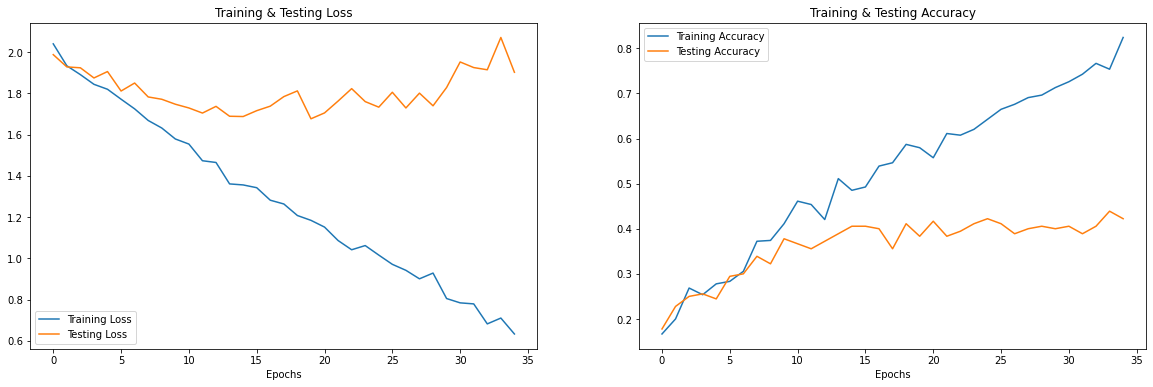

Random State : = 10
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 2s 72ms/step - loss: 2.0239 - accuracy: 0.1667 - val_loss: 1.9834 - val_accuracy: 0.1759
Epoch 2/35
17/17 [==============================] - 1s 84ms/step - loss: 1.9138 - accuracy: 0.2361 - val_loss: 1.9551 - val_accuracy: 0.2269
Epoch 3/35
17/17 [==============================] - 1s 37ms/step - loss: 1.8724 - accuracy: 0.2284 - val_loss: 1.9097 - val_accuracy: 0.2917
Epoch 4/35
17/17 [==============================] - 0s 8ms/step - loss: 1.8363 - accuracy: 0.2824 - val_loss: 1.9270 - val_accuracy: 0.2361
Epoch 5/35
17/17 [==============================] - 0s 13ms/step - loss: 1.7860 - accuracy: 0.2824 - val_loss: 1.8665 - val_accuracy: 0.2546
Epoch 6/35
17/17 [==============================] - 0s 26ms/step - loss: 1.7432 - accuracy: 0.3102 - val_loss: 1.84

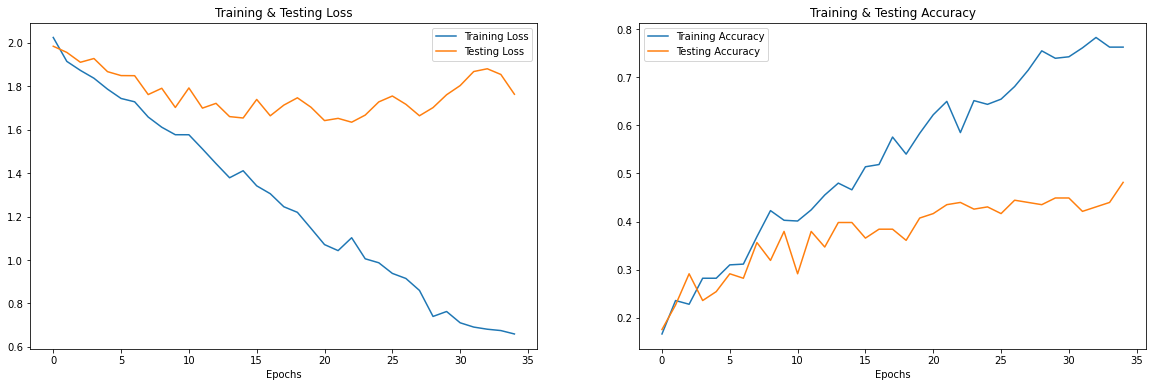

Random State : = 10
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 2s 68ms/step - loss: 2.0095 - accuracy: 0.1790 - val_loss: 1.9919 - val_accuracy: 0.2037
Epoch 2/35
21/21 [==============================] - 1s 41ms/step - loss: 1.9261 - accuracy: 0.2222 - val_loss: 1.9132 - val_accuracy: 0.2519
Epoch 3/35
21/21 [==============================] - 1s 48ms/step - loss: 1.8706 - accuracy: 0.2605 - val_loss: 1.8683 - val_accuracy: 0.2741
Epoch 4/35
21/21 [==============================] - 1s 52ms/step - loss: 1.8058 - accuracy: 0.2926 - val_loss: 1.8679 - val_accuracy: 0.2889
Epoch 5/35
21/21 [==============================] - 1s 42ms/step - loss: 1.7671 - accuracy: 0.3136 - val_loss: 1.8060 - val_accuracy: 0.2852
Epoch 6/35
21/21 [==============================] - 1s 44ms/step - loss: 1.6963 - accuracy: 0.3444 - val_loss: 1.7

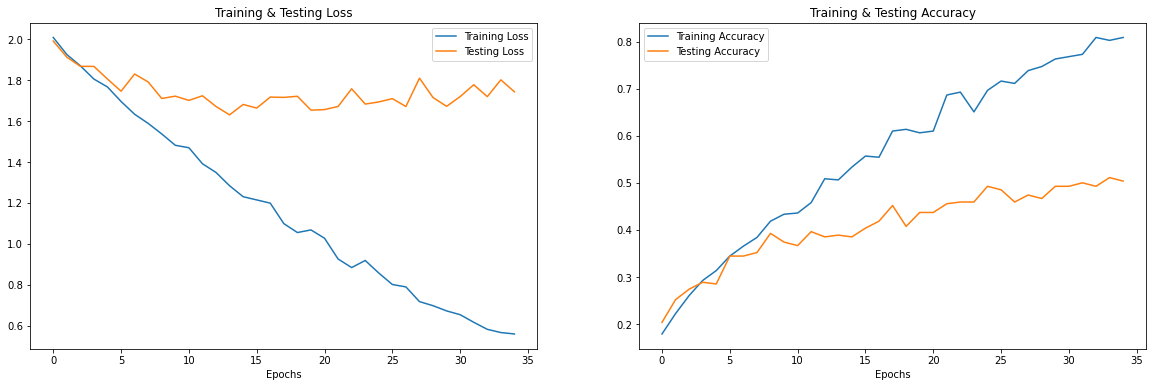

Random State : = 10
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 3s 105ms/step - loss: 2.0007 - accuracy: 0.1701 - val_loss: 1.9779 - val_accuracy: 0.2292
Epoch 2/35
22/22 [==============================] - 1s 31ms/step - loss: 1.9135 - accuracy: 0.2199 - val_loss: 1.9422 - val_accuracy: 0.2465
Epoch 3/35
22/22 [==============================] - 1s 34ms/step - loss: 1.8457 - accuracy: 0.2801 - val_loss: 1.9070 - val_accuracy: 0.2674
Epoch 4/35
22/22 [==============================] - 1s 23ms/step - loss: 1.7965 - accuracy: 0.2917 - val_loss: 1.9062 - val_accuracy: 0.3125
Epoch 5/35
22/22 [==============================] - 1s 25ms/step - loss: 1.7423 - accuracy: 0.3252 - val_loss: 1.8443 - val_accuracy: 0.2986
Epoch 6/35
22/22 [==============================] - 1s 30ms/step - loss: 1.6921 - accuracy: 0.3287 - val_loss: 1.

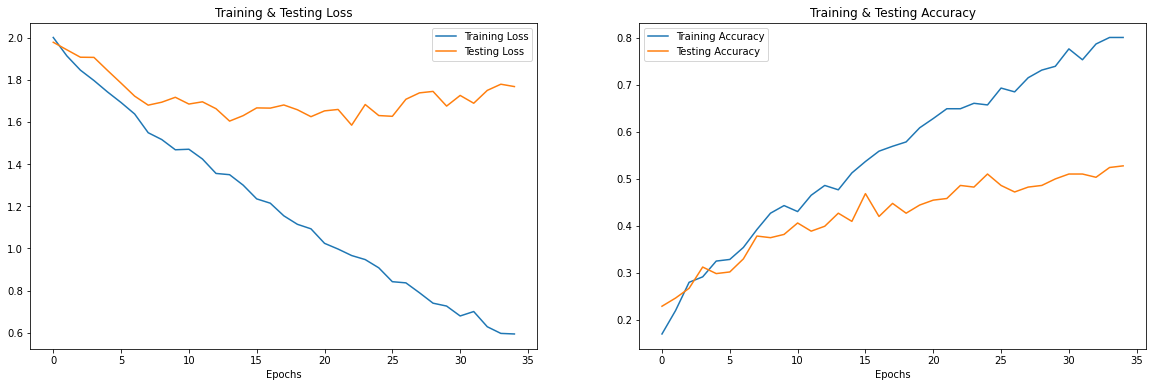

Random State : = 13
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 2s 80ms/step - loss: 2.0223 - accuracy: 0.1574 - val_loss: 1.9476 - val_accuracy: 0.1833
Epoch 2/35
14/14 [==============================] - 1s 41ms/step - loss: 1.9470 - accuracy: 0.2241 - val_loss: 1.9093 - val_accuracy: 0.2500
Epoch 3/35
14/14 [==============================] - 0s 23ms/step - loss: 1.9124 - accuracy: 0.2204 - val_loss: 1.8817 - val_accuracy: 0.2278
Epoch 4/35
14/14 [==============================] - 0s 24ms/step - loss: 1.8799 - accuracy: 0.2556 - val_loss: 1.8680 - val_accuracy: 0.2778
Epoch 5/35
14/14 [==============================] - 0s 33ms/step - loss: 1.8325 - accuracy: 0.3037 - val_loss: 1.8832 - val_accuracy: 0.2611
Epoch 6/35
14/14 [==============================] - 0s 28ms/step - loss: 1.7783 - accuracy: 0.3148 - val_loss: 1.8

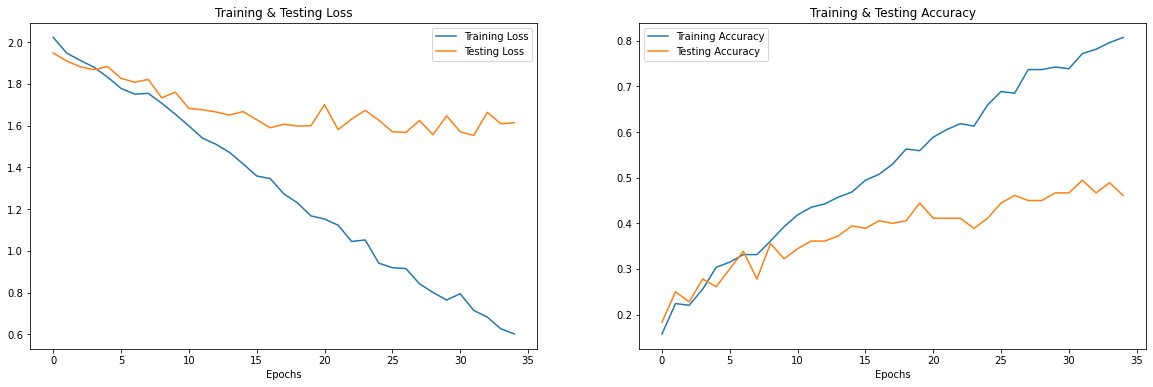

Random State : = 13
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 1s 20ms/step - loss: 2.0200 - accuracy: 0.1605 - val_loss: 1.9476 - val_accuracy: 0.2269
Epoch 2/35
17/17 [==============================] - 0s 27ms/step - loss: 1.9504 - accuracy: 0.2083 - val_loss: 1.8974 - val_accuracy: 0.2685
Epoch 3/35
17/17 [==============================] - 0s 24ms/step - loss: 1.8879 - accuracy: 0.2377 - val_loss: 1.8728 - val_accuracy: 0.3102
Epoch 4/35
17/17 [==============================] - 1s 37ms/step - loss: 1.8906 - accuracy: 0.2716 - val_loss: 1.8451 - val_accuracy: 0.2778
Epoch 5/35
17/17 [==============================] - 1s 35ms/step - loss: 1.8189 - accuracy: 0.3040 - val_loss: 1.8207 - val_accuracy: 0.2824
Epoch 6/35
17/17 [==============================] - 0s 21ms/step - loss: 1.7660 - accuracy: 0.3272 - val_loss: 1.7

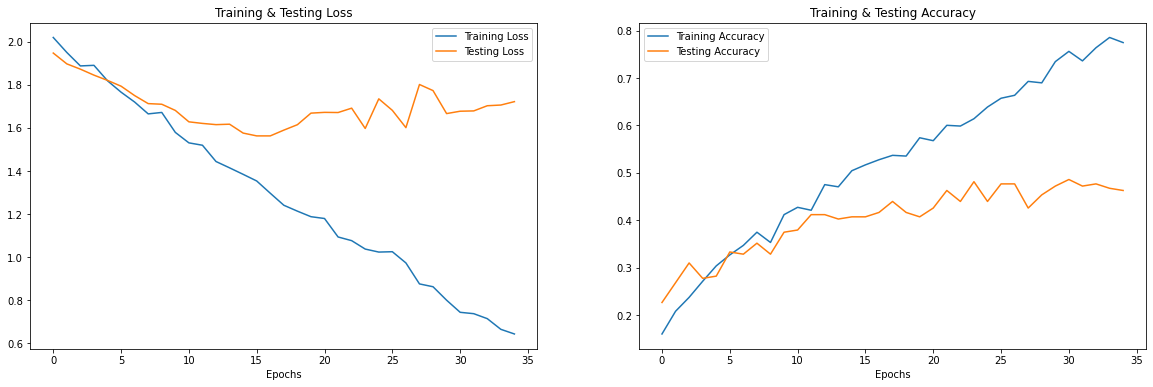

Random State : = 13
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 1s 36ms/step - loss: 2.0261 - accuracy: 0.1877 - val_loss: 1.9306 - val_accuracy: 0.2741
Epoch 2/35
21/21 [==============================] - 0s 24ms/step - loss: 1.9227 - accuracy: 0.2259 - val_loss: 1.8748 - val_accuracy: 0.2778
Epoch 3/35
21/21 [==============================] - 1s 37ms/step - loss: 1.8595 - accuracy: 0.2889 - val_loss: 1.8327 - val_accuracy: 0.2741
Epoch 4/35
21/21 [==============================] - 1s 25ms/step - loss: 1.7715 - accuracy: 0.3321 - val_loss: 1.8389 - val_accuracy: 0.2741
Epoch 5/35
21/21 [==============================] - 0s 21ms/step - loss: 1.7501 - accuracy: 0.3506 - val_loss: 1.7435 - val_accuracy: 0.3407
Epoch 6/35
21/21 [==============================] - 1s 29ms/step - loss: 1.6731 - accuracy: 0.3605 - val_loss: 1.7

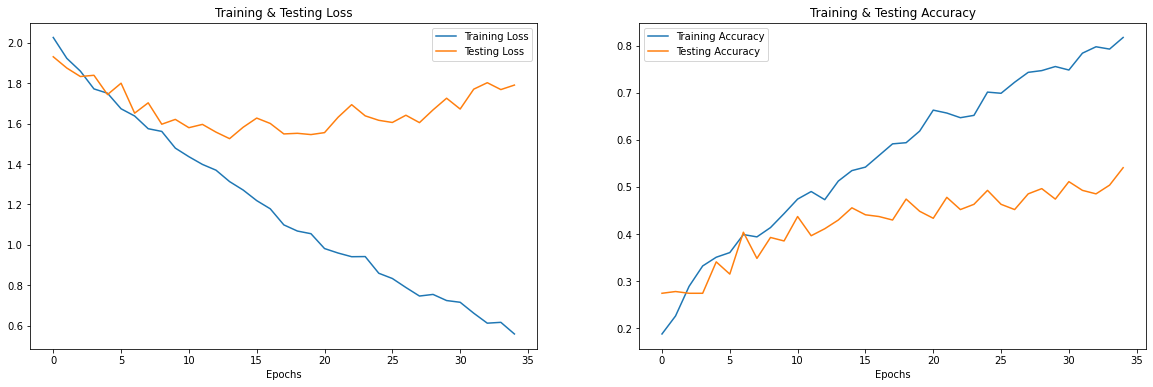

Random State : = 13
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 1s 23ms/step - loss: 1.9911 - accuracy: 0.1875 - val_loss: 1.9425 - val_accuracy: 0.2083
Epoch 2/35
22/22 [==============================] - 1s 42ms/step - loss: 1.8986 - accuracy: 0.2465 - val_loss: 1.8602 - val_accuracy: 0.2743
Epoch 3/35
22/22 [==============================] - 1s 46ms/step - loss: 1.8493 - accuracy: 0.2708 - val_loss: 1.8334 - val_accuracy: 0.3021
Epoch 4/35
22/22 [==============================] - 1s 25ms/step - loss: 1.7881 - accuracy: 0.3079 - val_loss: 1.8028 - val_accuracy: 0.2986
Epoch 5/35
22/22 [==============================] - 1s 26ms/step - loss: 1.7325 - accuracy: 0.3287 - val_loss: 1.7538 - val_accuracy: 0.3194
Epoch 6/35
22/22 [==============================] - 1s 26ms/step - loss: 1.6561 - accuracy: 0.3854 - val_loss: 1.6

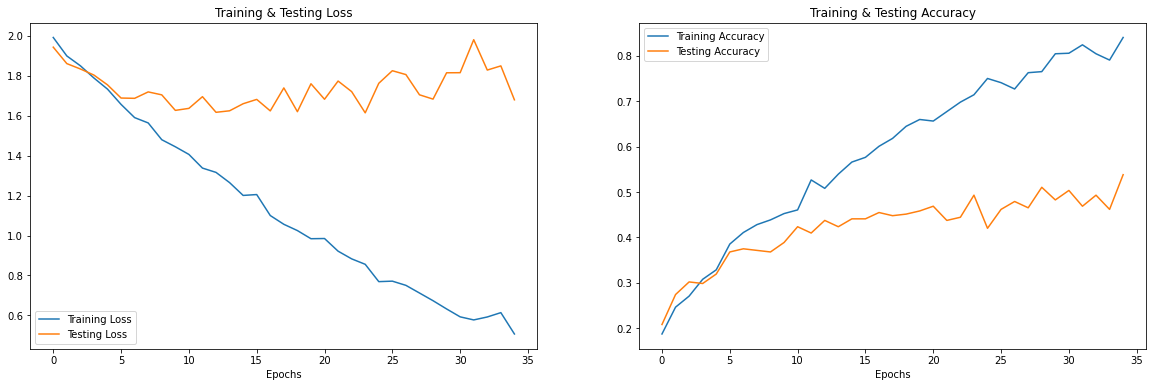

Random State : = 17
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 1s 54ms/step - loss: 2.0446 - accuracy: 0.1611 - val_loss: 1.9346 - val_accuracy: 0.2056
Epoch 2/35
14/14 [==============================] - 0s 13ms/step - loss: 1.9241 - accuracy: 0.2222 - val_loss: 1.8861 - val_accuracy: 0.2833
Epoch 3/35
14/14 [==============================] - 0s 18ms/step - loss: 1.9061 - accuracy: 0.2333 - val_loss: 1.8504 - val_accuracy: 0.2500
Epoch 4/35
14/14 [==============================] - 0s 28ms/step - loss: 1.8535 - accuracy: 0.2722 - val_loss: 1.8164 - val_accuracy: 0.3278
Epoch 5/35
14/14 [==============================] - 0s 26ms/step - loss: 1.8001 - accuracy: 0.2926 - val_loss: 1.8060 - val_accuracy: 0.3000
Epoch 6/35
14/14 [==============================] - 0s 24ms/step - loss: 1.7427 - accuracy: 0.3130 - val_loss: 1.7

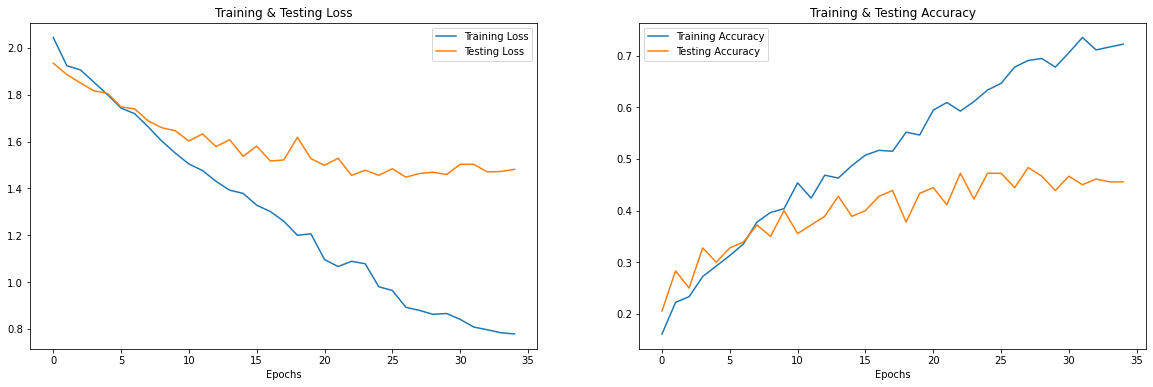

Random State : = 17
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 1s 20ms/step - loss: 2.0279 - accuracy: 0.1590 - val_loss: 1.9390 - val_accuracy: 0.1667
Epoch 2/35
17/17 [==============================] - 0s 26ms/step - loss: 1.9292 - accuracy: 0.2207 - val_loss: 1.9093 - val_accuracy: 0.2500
Epoch 3/35
17/17 [==============================] - 1s 33ms/step - loss: 1.9041 - accuracy: 0.2546 - val_loss: 1.8643 - val_accuracy: 0.2315
Epoch 4/35
17/17 [==============================] - 1s 36ms/step - loss: 1.8601 - accuracy: 0.2500 - val_loss: 1.8295 - val_accuracy: 0.2870
Epoch 5/35
17/17 [==============================] - 1s 31ms/step - loss: 1.8360 - accuracy: 0.2824 - val_loss: 1.8219 - val_accuracy: 0.3009
Epoch 6/35
17/17 [==============================] - 0s 17ms/step - loss: 1.7831 - accuracy: 0.3395 - val_loss: 1.7

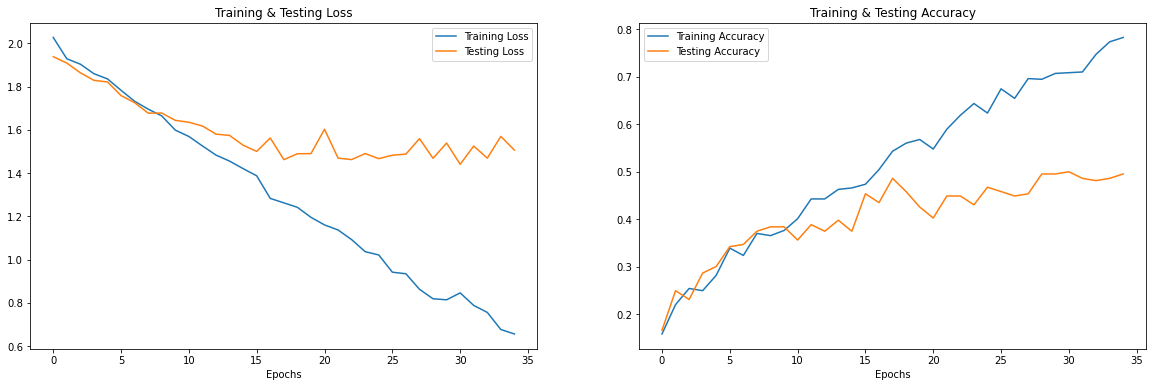

Random State : = 17
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 1s 21ms/step - loss: 2.0035 - accuracy: 0.1790 - val_loss: 1.9381 - val_accuracy: 0.2074
Epoch 2/35
21/21 [==============================] - 0s 24ms/step - loss: 1.9369 - accuracy: 0.2062 - val_loss: 1.8917 - val_accuracy: 0.2000
Epoch 3/35
21/21 [==============================] - 1s 37ms/step - loss: 1.8960 - accuracy: 0.2469 - val_loss: 1.8490 - val_accuracy: 0.2704
Epoch 4/35
21/21 [==============================] - 1s 35ms/step - loss: 1.8541 - accuracy: 0.2778 - val_loss: 1.8155 - val_accuracy: 0.2741
Epoch 5/35
21/21 [==============================] - 1s 25ms/step - loss: 1.8197 - accuracy: 0.2790 - val_loss: 1.7767 - val_accuracy: 0.3407
Epoch 6/35
21/21 [==============================] - 1s 30ms/step - loss: 1.7570 - accuracy: 0.3074 - val_loss: 1.7

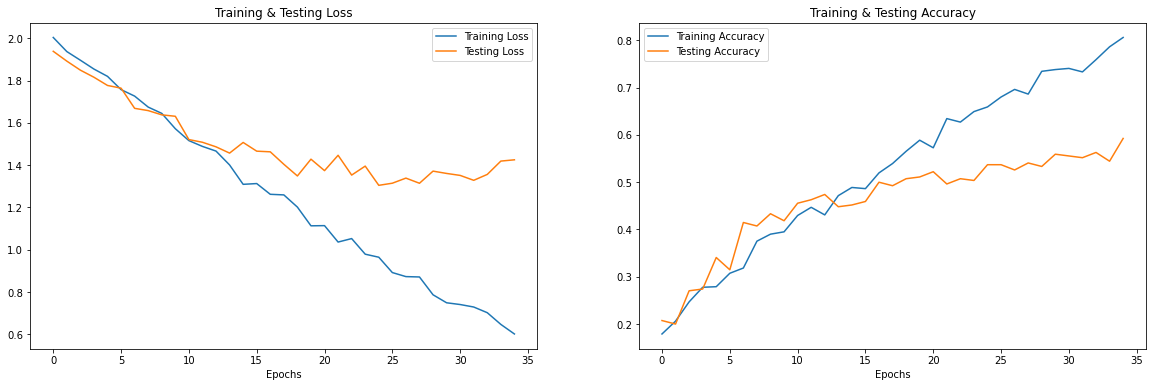

Random State : = 17
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 1s 25ms/step - loss: 2.0166 - accuracy: 0.1725 - val_loss: 1.9118 - val_accuracy: 0.2257
Epoch 2/35
22/22 [==============================] - 0s 18ms/step - loss: 1.9139 - accuracy: 0.2326 - val_loss: 1.8650 - val_accuracy: 0.2257
Epoch 3/35
22/22 [==============================] - 1s 40ms/step - loss: 1.8700 - accuracy: 0.2454 - val_loss: 1.8057 - val_accuracy: 0.3194
Epoch 4/35
22/22 [==============================] - 1s 41ms/step - loss: 1.8220 - accuracy: 0.2789 - val_loss: 1.7651 - val_accuracy: 0.2951
Epoch 5/35
22/22 [==============================] - 1s 36ms/step - loss: 1.7551 - accuracy: 0.3125 - val_loss: 1.7225 - val_accuracy: 0.3715
Epoch 6/35
22/22 [==============================] - 1s 29ms/step - loss: 1.7142 - accuracy: 0.3600 - val_loss: 1.7

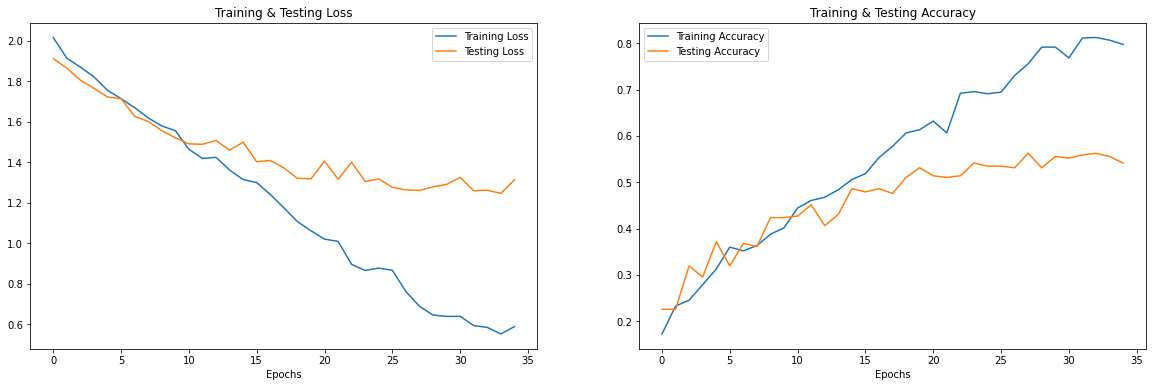

Random State : = 24
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 1s 23ms/step - loss: 2.0274 - accuracy: 0.1704 - val_loss: 1.9631 - val_accuracy: 0.1667
Epoch 2/35
14/14 [==============================] - 0s 35ms/step - loss: 1.9523 - accuracy: 0.2093 - val_loss: 1.9149 - val_accuracy: 0.2778
Epoch 3/35
14/14 [==============================] - 0s 38ms/step - loss: 1.8950 - accuracy: 0.2481 - val_loss: 1.8844 - val_accuracy: 0.2722
Epoch 4/35
14/14 [==============================] - 1s 37ms/step - loss: 1.8713 - accuracy: 0.2574 - val_loss: 1.8529 - val_accuracy: 0.3278
Epoch 5/35
14/14 [==============================] - 0s 30ms/step - loss: 1.8503 - accuracy: 0.3056 - val_loss: 1.8264 - val_accuracy: 0.3167
Epoch 6/35
14/14 [==============================] - 0s 14ms/step - loss: 1.7865 - accuracy: 0.3111 - val_loss: 1.7

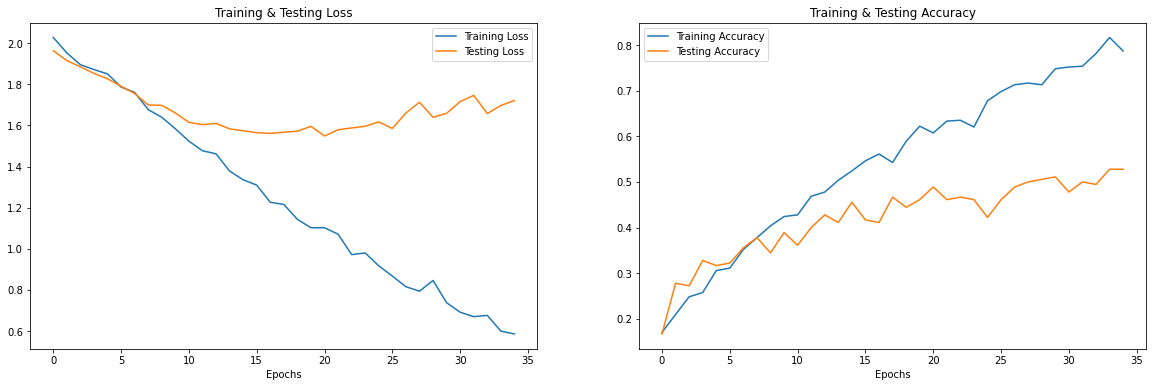

Random State : = 24
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 1s 20ms/step - loss: 2.0244 - accuracy: 0.1590 - val_loss: 1.9398 - val_accuracy: 0.2176
Epoch 2/35
17/17 [==============================] - 1s 39ms/step - loss: 1.9031 - accuracy: 0.2330 - val_loss: 1.8703 - val_accuracy: 0.2593
Epoch 3/35
17/17 [==============================] - 1s 41ms/step - loss: 1.8737 - accuracy: 0.2639 - val_loss: 1.8476 - val_accuracy: 0.3750
Epoch 4/35
17/17 [==============================] - 1s 42ms/step - loss: 1.8206 - accuracy: 0.2994 - val_loss: 1.8329 - val_accuracy: 0.2731
Epoch 5/35
17/17 [==============================] - 1s 43ms/step - loss: 1.7926 - accuracy: 0.3272 - val_loss: 1.8138 - val_accuracy: 0.3519
Epoch 6/35
17/17 [==============================] - 0s 25ms/step - loss: 1.7331 - accuracy: 0.3395 - val_loss: 1.7

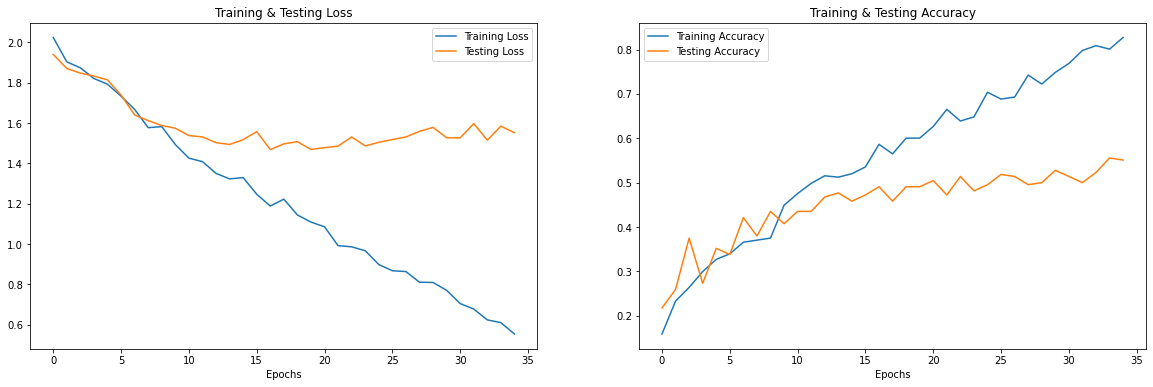

Random State : = 24
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 1s 18ms/step - loss: 1.9912 - accuracy: 0.1938 - val_loss: 1.9304 - val_accuracy: 0.2185
Epoch 2/35
21/21 [==============================] - 0s 8ms/step - loss: 1.9151 - accuracy: 0.2333 - val_loss: 1.8967 - val_accuracy: 0.2778
Epoch 3/35
21/21 [==============================] - 0s 8ms/step - loss: 1.8853 - accuracy: 0.2346 - val_loss: 1.8623 - val_accuracy: 0.2815
Epoch 4/35
21/21 [==============================] - 0s 24ms/step - loss: 1.8560 - accuracy: 0.2617 - val_loss: 1.8295 - val_accuracy: 0.3037
Epoch 5/35
21/21 [==============================] - 1s 35ms/step - loss: 1.8006 - accuracy: 0.3074 - val_loss: 1.8102 - val_accuracy: 0.3222
Epoch 6/35
21/21 [==============================] - 0s 22ms/step - loss: 1.7631 - accuracy: 0.3247 - val_loss: 1.764

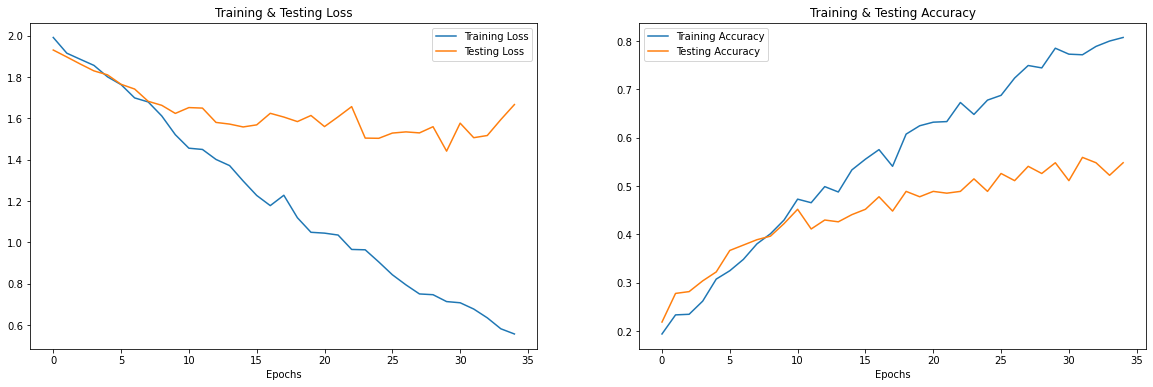

Random State : = 24
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 1s 31ms/step - loss: 1.9931 - accuracy: 0.1829 - val_loss: 1.9347 - val_accuracy: 0.2153
Epoch 2/35
22/22 [==============================] - 1s 40ms/step - loss: 1.8969 - accuracy: 0.2523 - val_loss: 1.8641 - val_accuracy: 0.2431
Epoch 3/35
22/22 [==============================] - 1s 42ms/step - loss: 1.8454 - accuracy: 0.2639 - val_loss: 1.7985 - val_accuracy: 0.2986
Epoch 4/35
22/22 [==============================] - 1s 35ms/step - loss: 1.7837 - accuracy: 0.2951 - val_loss: 1.7829 - val_accuracy: 0.3472
Epoch 5/35
22/22 [==============================] - 1s 40ms/step - loss: 1.7015 - accuracy: 0.3565 - val_loss: 1.7310 - val_accuracy: 0.3681
Epoch 6/35
22/22 [==============================] - 1s 40ms/step - loss: 1.6843 - accuracy: 0.3565 - val_loss: 1.6

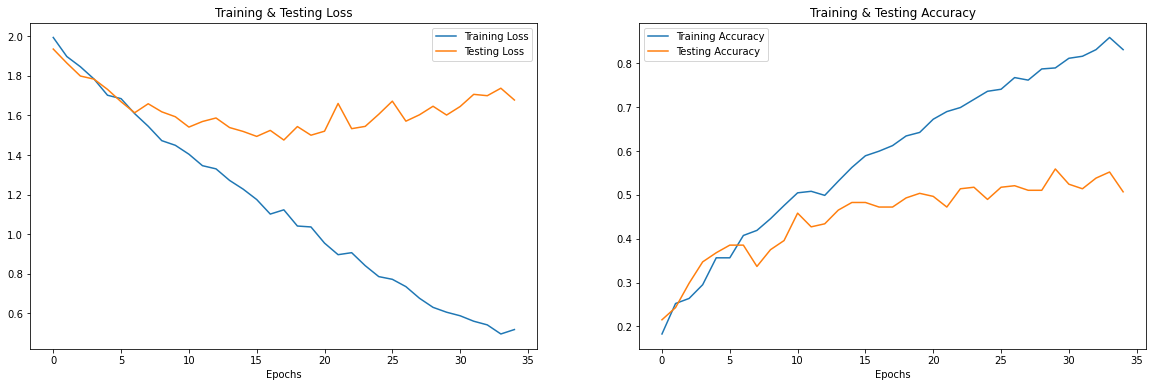

Random State : = 51
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 1s 24ms/step - loss: 2.0212 - accuracy: 0.1722 - val_loss: 1.9341 - val_accuracy: 0.2500
Epoch 2/35
14/14 [==============================] - 1s 36ms/step - loss: 1.9188 - accuracy: 0.2426 - val_loss: 1.9082 - val_accuracy: 0.2278
Epoch 3/35
14/14 [==============================] - 1s 43ms/step - loss: 1.9183 - accuracy: 0.2463 - val_loss: 1.8583 - val_accuracy: 0.2389
Epoch 4/35
14/14 [==============================] - 1s 41ms/step - loss: 1.8759 - accuracy: 0.2704 - val_loss: 1.8469 - val_accuracy: 0.2444
Epoch 5/35
14/14 [==============================] - 1s 42ms/step - loss: 1.8051 - accuracy: 0.3000 - val_loss: 1.8639 - val_accuracy: 0.2333
Epoch 6/35
14/14 [==============================] - 1s 43ms/step - loss: 1.7790 - accuracy: 0.3315 - val_loss: 1.7

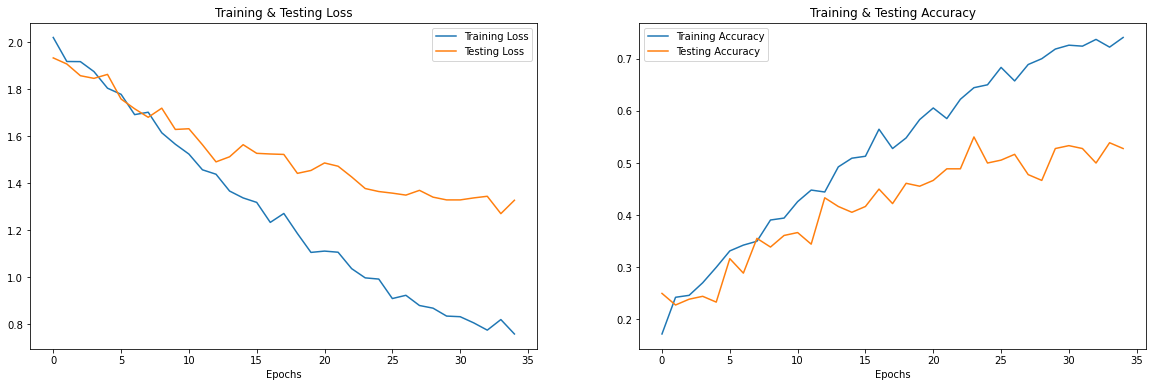

Random State : = 51
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 2s 55ms/step - loss: 2.0302 - accuracy: 0.1358 - val_loss: 1.9254 - val_accuracy: 0.1991
Epoch 2/35
17/17 [==============================] - 1s 42ms/step - loss: 1.9383 - accuracy: 0.2145 - val_loss: 1.8782 - val_accuracy: 0.2639
Epoch 3/35
17/17 [==============================] - 1s 31ms/step - loss: 1.8900 - accuracy: 0.2824 - val_loss: 1.8395 - val_accuracy: 0.2917
Epoch 4/35
17/17 [==============================] - 0s 27ms/step - loss: 1.8210 - accuracy: 0.3194 - val_loss: 1.8104 - val_accuracy: 0.3519
Epoch 5/35
17/17 [==============================] - 1s 37ms/step - loss: 1.8186 - accuracy: 0.3056 - val_loss: 1.7567 - val_accuracy: 0.3380
Epoch 6/35
17/17 [==============================] - 1s 38ms/step - loss: 1.7778 - accuracy: 0.3210 - val_loss: 1.7

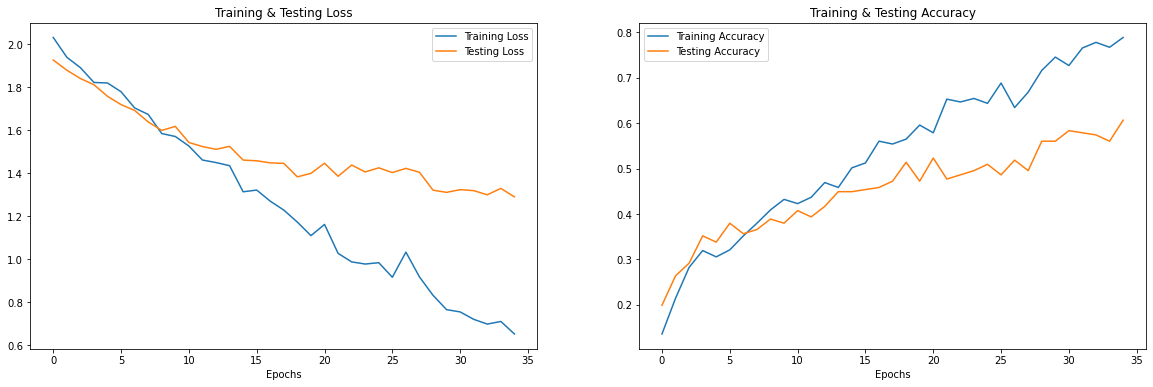

Random State : = 51
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 1s 37ms/step - loss: 2.0177 - accuracy: 0.1963 - val_loss: 1.9033 - val_accuracy: 0.2111
Epoch 2/35
21/21 [==============================] - 1s 48ms/step - loss: 1.8895 - accuracy: 0.2259 - val_loss: 1.8689 - val_accuracy: 0.2667
Epoch 3/35
21/21 [==============================] - 1s 48ms/step - loss: 1.8850 - accuracy: 0.2519 - val_loss: 1.8096 - val_accuracy: 0.2889
Epoch 4/35
21/21 [==============================] - 1s 34ms/step - loss: 1.8297 - accuracy: 0.2605 - val_loss: 1.7717 - val_accuracy: 0.2815
Epoch 5/35
21/21 [==============================] - 1s 27ms/step - loss: 1.7551 - accuracy: 0.2975 - val_loss: 1.7298 - val_accuracy: 0.3074
Epoch 6/35
21/21 [==============================] - 1s 31ms/step - loss: 1.7149 - accuracy: 0.3432 - val_loss: 1.6

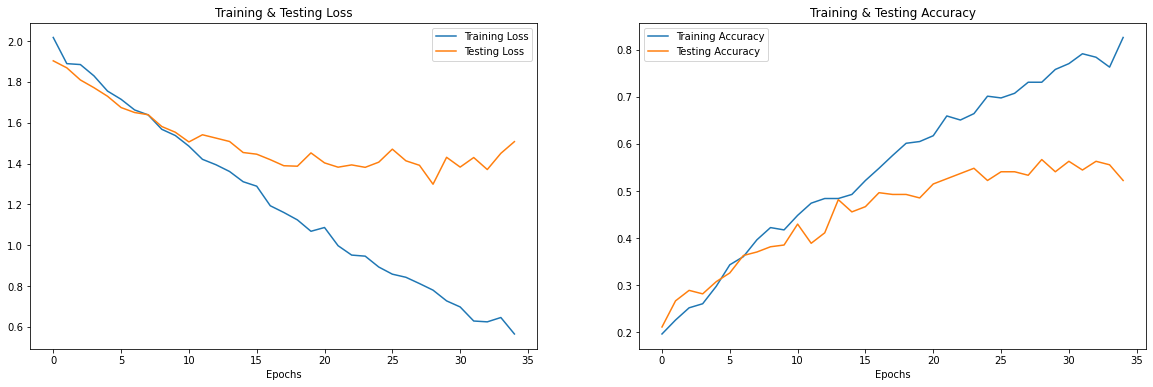

Random State : = 51
-------------------
Traing is done for Model 2
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 1s 25ms/step - loss: 2.0022 - accuracy: 0.1991 - val_loss: 1.9405 - val_accuracy: 0.2014
Epoch 2/35
22/22 [==============================] - 0s 14ms/step - loss: 1.9049 - accuracy: 0.2674 - val_loss: 1.8701 - val_accuracy: 0.2188
Epoch 3/35
22/22 [==============================] - 1s 32ms/step - loss: 1.8665 - accuracy: 0.2488 - val_loss: 1.8140 - val_accuracy: 0.2882
Epoch 4/35
22/22 [==============================] - 1s 59ms/step - loss: 1.7910 - accuracy: 0.3044 - val_loss: 1.7363 - val_accuracy: 0.3264
Epoch 5/35
22/22 [==============================] - 1s 38ms/step - loss: 1.7165 - accuracy: 0.3368 - val_loss: 1.7067 - val_accuracy: 0.3056
Epoch 6/35
22/22 [==============================] - 1s 40ms/step - loss: 1.6619 - accuracy: 0.3773 - val_loss: 1.6

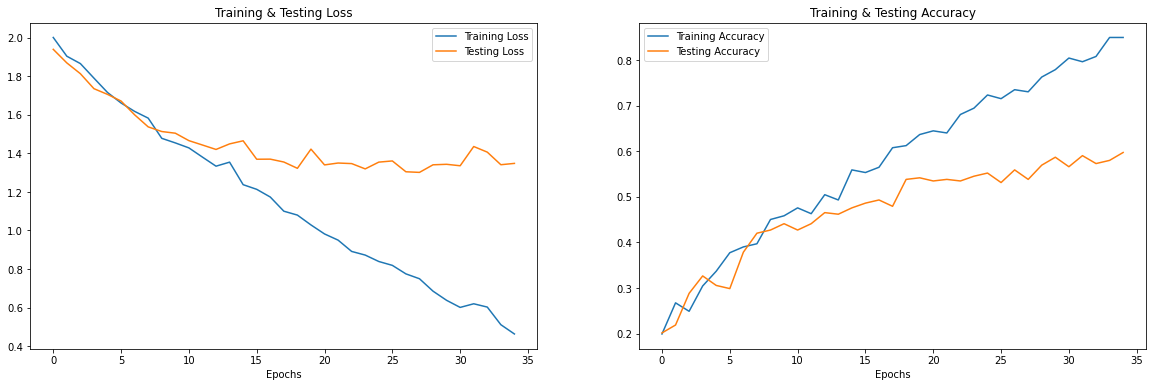

In [54]:
for x_trains,y_trains,x_tests,y_tests,rs in prog_bar(get_simple_train_test_xy(),total=5):
    Simple_Model_2_dict = {}
    Simple_Histories_2 = {}
    for k in cg:
        Simple_Model_2_dict[k] = model_2(x_trains[k])
        print(f"Random State : = {rs}")
        print("-------------------")
        print(f"Traing is done for Model 2")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        Simple_Histories_2[k] = Simple_Model_2_dict[k].fit(x_trains[k], y_trains[k], 
                                    batch_size=40, 
                                    epochs=epoch, 
                                    validation_split=.25, 
                                    callbacks=[rlrp])
        
        print("-------------------")
        print(f"Traing is done for Model 2")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        simple_model_2_acc_matrix[k].append(loss_accuracy_details(Simple_Model_2_dict[k],
                                                            Simple_Histories_2[k],
                                                            epoch,x_tests[k],
                                                            y_tests[k]
                                                            ))
        if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_2',k)):
            os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_2',k))
        Simple_Model_2_dict[k].save(os.path.join("Models",'simple@model_2',k,f"simple@model_2_{'_'.join(TTS_DICT[k])}_{rs}.h5"))

In [55]:
simple_model_2_acc_Df = pd.DataFrame(simple_model_2_acc_matrix,index=random_states).T
path_to_model_acc_matrix = os.path.abspath('Model_Acc_Matrices')
simple_model_2_acc_Df.to_csv(os.path.join(path_to_model_acc_matrix,'simple_model_2_acc_mat.csv'))
simple_model_2_acc_Df.head()

,10,13,17,24,51
a,54.166669,49.583334,47.083333,51.527780,49.444443
b,51.388890,56.423610,47.916666,53.472221,50.520831
c,55.277777,52.499998,54.722220,51.944447,49.444443
d,59.722221,50.347221,53.819442,51.736110,59.027779


In [56]:
simple_model_2_acc_Df.T.describe()

,a,b,c,d
count,5.000000,5.000000,5.000000,5.000000
mean,50.361112,51.944444,52.777777,54.930555
std,2.647283,3.199818,2.340597,4.248332
min,47.083333,47.916666,49.444443,50.347221
25%,49.444443,50.520831,51.944447,51.736110
50%,49.583334,51.388890,52.499998,53.819442
75%,51.527780,53.472221,54.722220,59.027779
max,54.166669,56.423610,55.277777,59.722221


## Model 3
----

In [57]:
if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_3')):
    os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_3'))

In [58]:
def model_3(x_train):
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=3, strides = 3, padding = 'same'))

    model.add(Conv1D(256, kernel_size=9, strides=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=7, strides = 5, padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))


    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

In [61]:
simple_model_3_acc_matrix = {}
for k in cg:
    simple_model_3_acc_matrix[k] = list()
print(simple_model_3_acc_matrix)



{'a': [], 'b': [], 'c': [], 'd': []}


  0%|          | 0/5 [00:00<?, ?it/s]

Random State : = 10
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 1s 53ms/step - loss: 2.0194 - accuracy: 0.1759 - val_loss: 1.9075 - val_accuracy: 0.2111
Epoch 2/35
14/14 [==============================] - 1s 50ms/step - loss: 1.8679 - accuracy: 0.2500 - val_loss: 1.9287 - val_accuracy: 0.2611
Epoch 3/35
14/14 [==============================] - 1s 50ms/step - loss: 1.8169 - accuracy: 0.2852 - val_loss: 1.8246 - val_accuracy: 0.3000
Epoch 4/35
14/14 [==============================] - 1s 49ms/step - loss: 1.7013 - accuracy: 0.3556 - val_loss: 1.8180 - val_accuracy: 0.3000
Epoch 5/35
14/14 [==============================] - 0s 35ms/step - loss: 1.6441 - accuracy: 0.3963 - val_loss: 1.7995 - val_accuracy: 0.3556
Epoch 6/35
14/14 [==============================] - 1s 41ms/step - loss: 1.6346 - accuracy: 0.3852 - val_loss: 1.

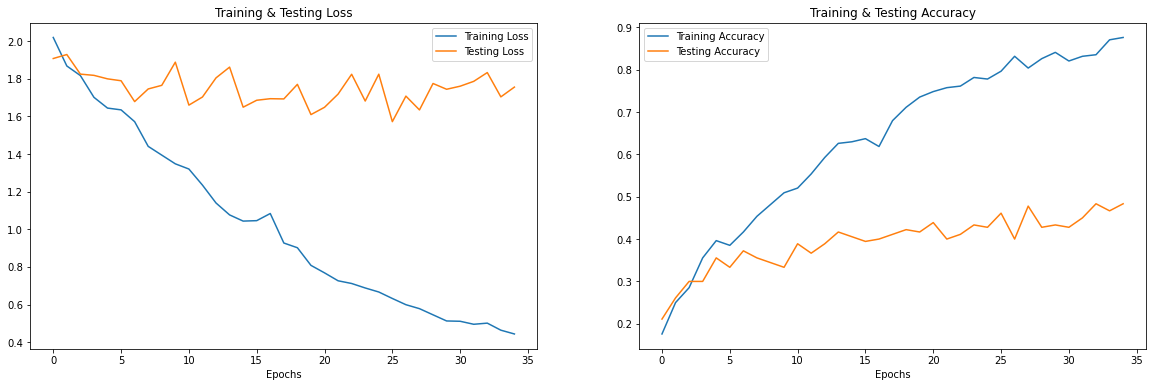

Random State : = 10
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 3s 123ms/step - loss: 2.0062 - accuracy: 0.1867 - val_loss: 2.0030 - val_accuracy: 0.1991
Epoch 2/35
17/17 [==============================] - 1s 52ms/step - loss: 1.8995 - accuracy: 0.2346 - val_loss: 1.8787 - val_accuracy: 0.2778
Epoch 3/35
17/17 [==============================] - 1s 38ms/step - loss: 1.8408 - accuracy: 0.2793 - val_loss: 1.9205 - val_accuracy: 0.2407
Epoch 4/35
17/17 [==============================] - 1s 39ms/step - loss: 1.7541 - accuracy: 0.3380 - val_loss: 1.8357 - val_accuracy: 0.3056
Epoch 5/35
17/17 [==============================] - 1s 43ms/step - loss: 1.7104 - accuracy: 0.3364 - val_loss: 1.8002 - val_accuracy: 0.3565
Epoch 6/35
17/17 [==============================] - 1s 51ms/step - loss: 1.5807 - accuracy: 0.4028 - val_loss: 1

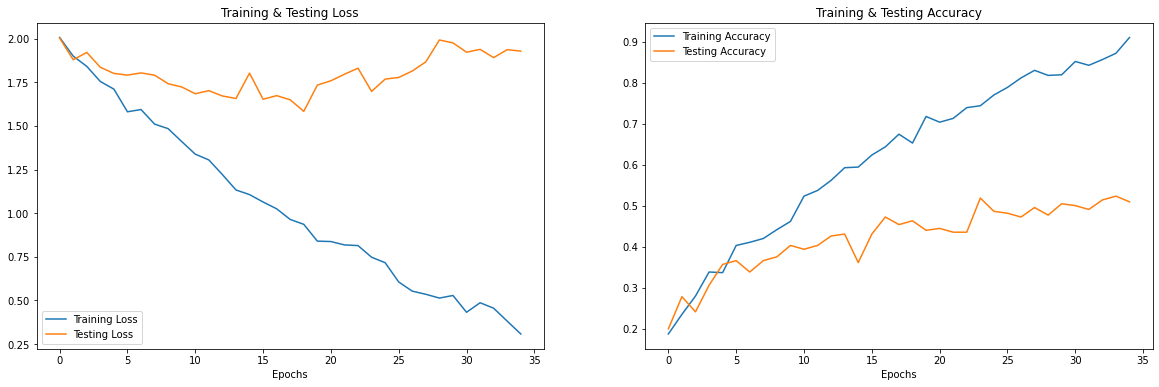

Random State : = 10
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 3s 104ms/step - loss: 1.9767 - accuracy: 0.2062 - val_loss: 1.9060 - val_accuracy: 0.2407
Epoch 2/35
21/21 [==============================] - 1s 70ms/step - loss: 1.8711 - accuracy: 0.2667 - val_loss: 1.8425 - val_accuracy: 0.2593
Epoch 3/35
21/21 [==============================] - 1s 41ms/step - loss: 1.7725 - accuracy: 0.3025 - val_loss: 1.8349 - val_accuracy: 0.3481
Epoch 4/35
21/21 [==============================] - 1s 42ms/step - loss: 1.6960 - accuracy: 0.3346 - val_loss: 1.7977 - val_accuracy: 0.3556
Epoch 5/35
21/21 [==============================] - 1s 47ms/step - loss: 1.6402 - accuracy: 0.3741 - val_loss: 1.7122 - val_accuracy: 0.3667
Epoch 6/35
21/21 [==============================] - 1s 47ms/step - loss: 1.5245 - accuracy: 0.4074 - val_loss: 1

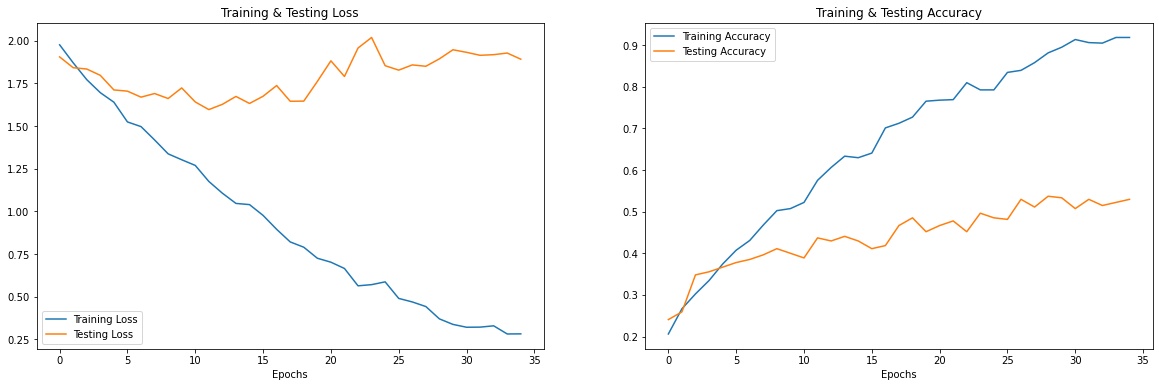

Random State : = 10
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 3s 102ms/step - loss: 1.9699 - accuracy: 0.2095 - val_loss: 1.9007 - val_accuracy: 0.2708
Epoch 2/35
22/22 [==============================] - 1s 45ms/step - loss: 1.8007 - accuracy: 0.2905 - val_loss: 1.8759 - val_accuracy: 0.3021
Epoch 3/35
22/22 [==============================] - 1s 43ms/step - loss: 1.7325 - accuracy: 0.3345 - val_loss: 1.8013 - val_accuracy: 0.3264
Epoch 4/35
22/22 [==============================] - 1s 40ms/step - loss: 1.6667 - accuracy: 0.3322 - val_loss: 1.7822 - val_accuracy: 0.3403
Epoch 5/35
22/22 [==============================] - 1s 43ms/step - loss: 1.5888 - accuracy: 0.3715 - val_loss: 1.7772 - val_accuracy: 0.3611
Epoch 6/35
22/22 [==============================] - 1s 45ms/step - loss: 1.5595 - accuracy: 0.4178 - val_loss: 1

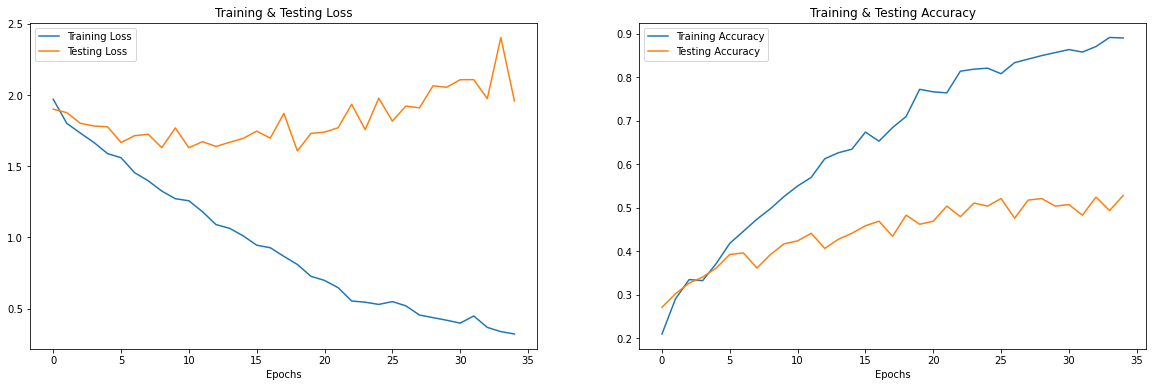

Random State : = 13
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 2s 119ms/step - loss: 1.9954 - accuracy: 0.1926 - val_loss: 1.8999 - val_accuracy: 0.2333
Epoch 2/35
14/14 [==============================] - 1s 60ms/step - loss: 1.8996 - accuracy: 0.2481 - val_loss: 1.8646 - val_accuracy: 0.3111
Epoch 3/35
14/14 [==============================] - 1s 47ms/step - loss: 1.8185 - accuracy: 0.3130 - val_loss: 1.8101 - val_accuracy: 0.3167
Epoch 4/35
14/14 [==============================] - 1s 46ms/step - loss: 1.7669 - accuracy: 0.3352 - val_loss: 1.7852 - val_accuracy: 0.3278
Epoch 5/35
14/14 [==============================] - 1s 41ms/step - loss: 1.6813 - accuracy: 0.3778 - val_loss: 1.7369 - val_accuracy: 0.3722
Epoch 6/35
14/14 [==============================] - 1s 49ms/step - loss: 1.5957 - accuracy: 0.4241 - val_loss: 1

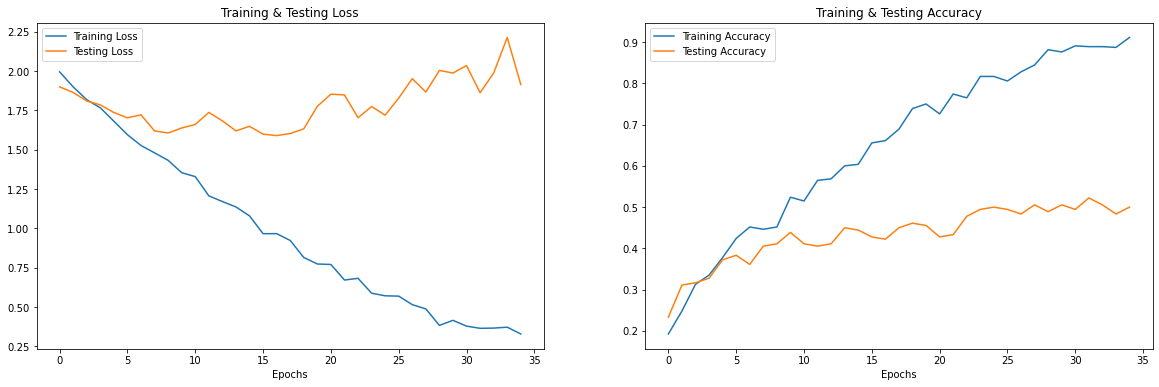

Random State : = 13
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 2s 65ms/step - loss: 2.0093 - accuracy: 0.1682 - val_loss: 1.9226 - val_accuracy: 0.2361
Epoch 2/35
17/17 [==============================] - 1s 57ms/step - loss: 1.8837 - accuracy: 0.2639 - val_loss: 1.8644 - val_accuracy: 0.2685
Epoch 3/35
17/17 [==============================] - 1s 48ms/step - loss: 1.8197 - accuracy: 0.2963 - val_loss: 1.7927 - val_accuracy: 0.2963
Epoch 4/35
17/17 [==============================] - 1s 43ms/step - loss: 1.7372 - accuracy: 0.3457 - val_loss: 1.7446 - val_accuracy: 0.3287
Epoch 5/35
17/17 [==============================] - 1s 42ms/step - loss: 1.6776 - accuracy: 0.3704 - val_loss: 1.6902 - val_accuracy: 0.3426
Epoch 6/35
17/17 [==============================] - 1s 49ms/step - loss: 1.5924 - accuracy: 0.4290 - val_loss: 1.

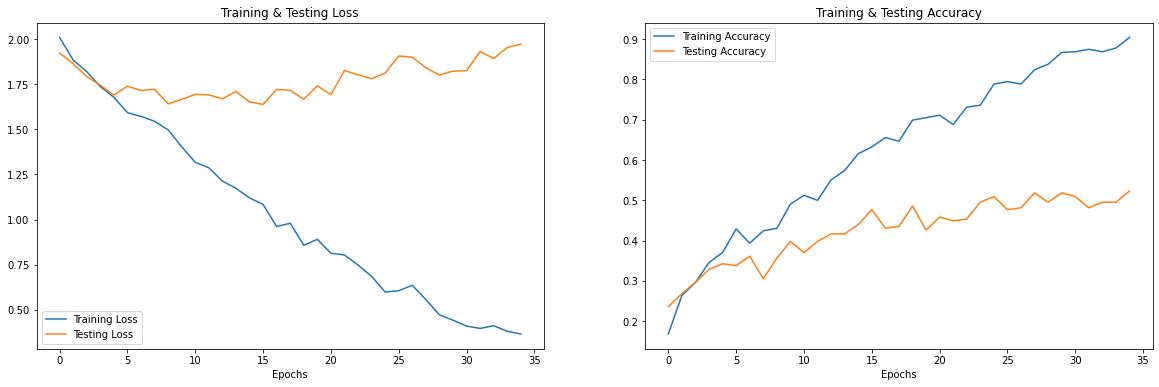

Random State : = 13
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 2s 56ms/step - loss: 1.9744 - accuracy: 0.2346 - val_loss: 1.8906 - val_accuracy: 0.2556
Epoch 2/35
21/21 [==============================] - 1s 51ms/step - loss: 1.8527 - accuracy: 0.2543 - val_loss: 1.8385 - val_accuracy: 0.3407
Epoch 3/35
21/21 [==============================] - 1s 54ms/step - loss: 1.7347 - accuracy: 0.3494 - val_loss: 1.7535 - val_accuracy: 0.3185
Epoch 4/35
21/21 [==============================] - 1s 48ms/step - loss: 1.6349 - accuracy: 0.3938 - val_loss: 1.7512 - val_accuracy: 0.3481
Epoch 5/35
21/21 [==============================] - 1s 36ms/step - loss: 1.5951 - accuracy: 0.3864 - val_loss: 1.7002 - val_accuracy: 0.3815
Epoch 6/35
21/21 [==============================] - 1s 48ms/step - loss: 1.4864 - accuracy: 0.4383 - val_loss: 1.

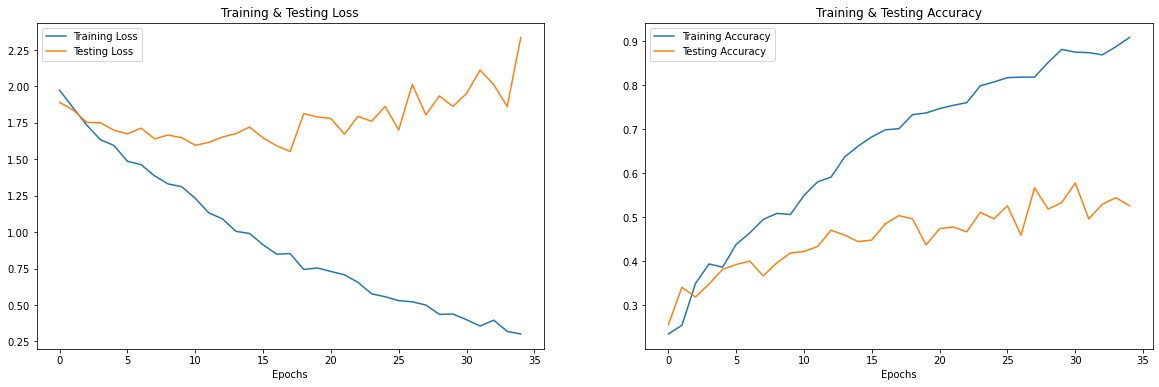

Random State : = 13
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 2s 49ms/step - loss: 1.9960 - accuracy: 0.1933 - val_loss: 1.9126 - val_accuracy: 0.2292
Epoch 2/35
22/22 [==============================] - 1s 52ms/step - loss: 1.8501 - accuracy: 0.2905 - val_loss: 1.8559 - val_accuracy: 0.2778
Epoch 3/35
22/22 [==============================] - 1s 49ms/step - loss: 1.7437 - accuracy: 0.3171 - val_loss: 1.7858 - val_accuracy: 0.3576
Epoch 4/35
22/22 [==============================] - 1s 41ms/step - loss: 1.6423 - accuracy: 0.3692 - val_loss: 1.7514 - val_accuracy: 0.3368
Epoch 5/35
22/22 [==============================] - 1s 38ms/step - loss: 1.5551 - accuracy: 0.4086 - val_loss: 1.7667 - val_accuracy: 0.3264
Epoch 6/35
22/22 [==============================] - 1s 43ms/step - loss: 1.5622 - accuracy: 0.4086 - val_loss: 1.

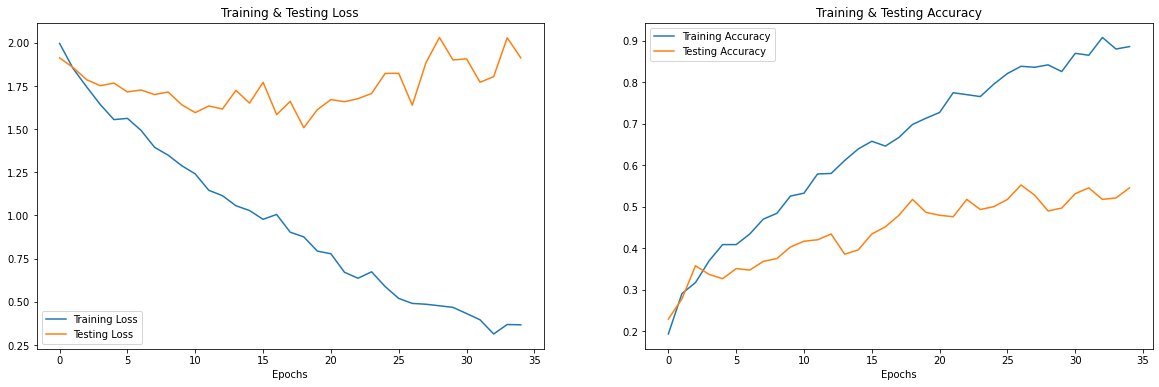

Random State : = 17
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 1s 64ms/step - loss: 1.9955 - accuracy: 0.1926 - val_loss: 1.8982 - val_accuracy: 0.2000
Epoch 2/35
14/14 [==============================] - 1s 58ms/step - loss: 1.8851 - accuracy: 0.2667 - val_loss: 1.8618 - val_accuracy: 0.2833
Epoch 3/35
14/14 [==============================] - 1s 57ms/step - loss: 1.8384 - accuracy: 0.2815 - val_loss: 1.8588 - val_accuracy: 0.2889
Epoch 4/35
14/14 [==============================] - 1s 49ms/step - loss: 1.7515 - accuracy: 0.3352 - val_loss: 1.8242 - val_accuracy: 0.2333
Epoch 5/35
14/14 [==============================] - 1s 39ms/step - loss: 1.7632 - accuracy: 0.3074 - val_loss: 1.7789 - val_accuracy: 0.3333
Epoch 6/35
14/14 [==============================] - 1s 42ms/step - loss: 1.6771 - accuracy: 0.3889 - val_loss: 1.

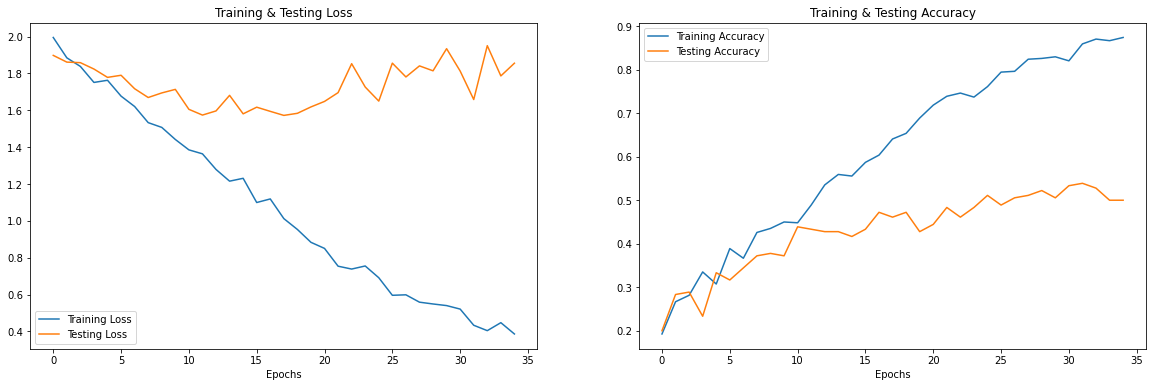

Random State : = 17
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 2s 59ms/step - loss: 1.9686 - accuracy: 0.2068 - val_loss: 1.9006 - val_accuracy: 0.3102
Epoch 2/35
17/17 [==============================] - 1s 52ms/step - loss: 1.8793 - accuracy: 0.2438 - val_loss: 1.8368 - val_accuracy: 0.2546
Epoch 3/35
17/17 [==============================] - 1s 51ms/step - loss: 1.8134 - accuracy: 0.2731 - val_loss: 1.7982 - val_accuracy: 0.3102
Epoch 4/35
17/17 [==============================] - 1s 38ms/step - loss: 1.7224 - accuracy: 0.3333 - val_loss: 1.7183 - val_accuracy: 0.3102
Epoch 5/35
17/17 [==============================] - 1s 38ms/step - loss: 1.6551 - accuracy: 0.3549 - val_loss: 1.6914 - val_accuracy: 0.3565
Epoch 6/35
17/17 [==============================] - 1s 47ms/step - loss: 1.5886 - accuracy: 0.3966 - val_loss: 1.

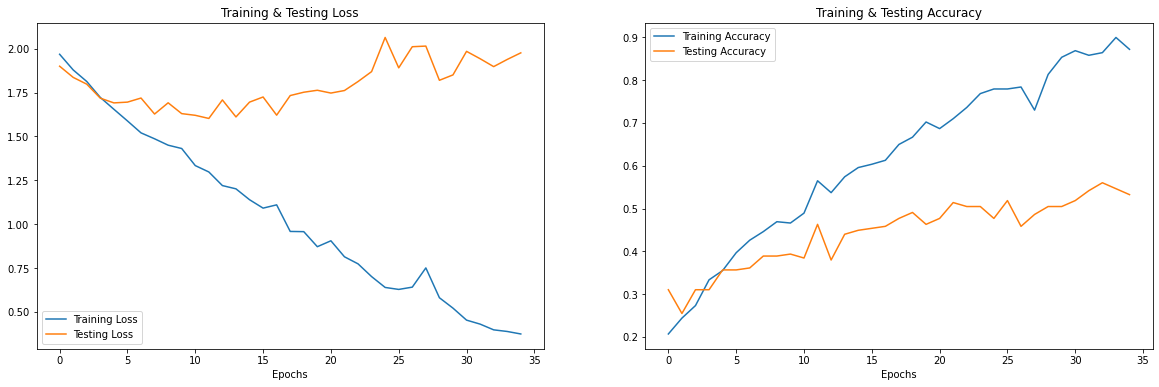

Random State : = 17
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 2s 53ms/step - loss: 2.0186 - accuracy: 0.2123 - val_loss: 1.9575 - val_accuracy: 0.2667
Epoch 2/35
21/21 [==============================] - 1s 54ms/step - loss: 1.9046 - accuracy: 0.2383 - val_loss: 1.8290 - val_accuracy: 0.2852
Epoch 3/35
21/21 [==============================] - 1s 46ms/step - loss: 1.8077 - accuracy: 0.2679 - val_loss: 1.7309 - val_accuracy: 0.4074
Epoch 4/35
21/21 [==============================] - 1s 40ms/step - loss: 1.7214 - accuracy: 0.3284 - val_loss: 1.6649 - val_accuracy: 0.3926
Epoch 5/35
21/21 [==============================] - 1s 41ms/step - loss: 1.6443 - accuracy: 0.3679 - val_loss: 1.6592 - val_accuracy: 0.3852
Epoch 6/35
21/21 [==============================] - 1s 42ms/step - loss: 1.5871 - accuracy: 0.3691 - val_loss: 1.

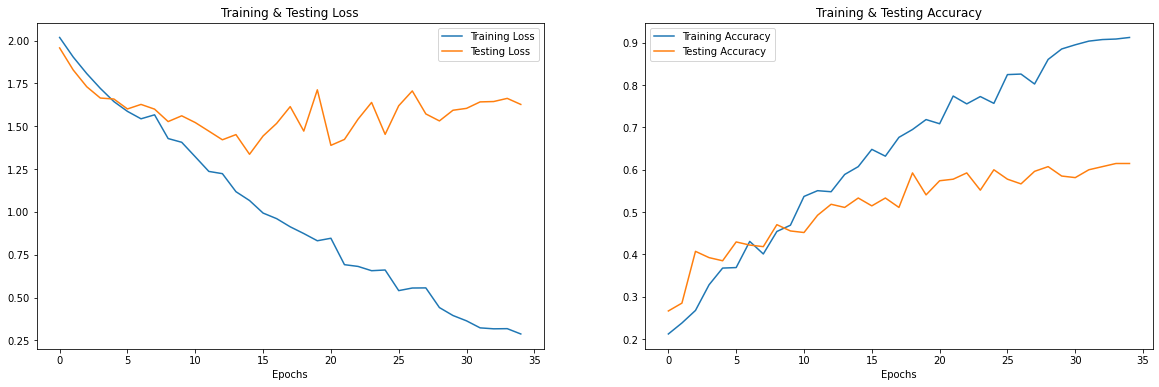

Random State : = 17
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 2s 59ms/step - loss: 1.9907 - accuracy: 0.1852 - val_loss: 1.8714 - val_accuracy: 0.3299
Epoch 2/35
22/22 [==============================] - 1s 55ms/step - loss: 1.8779 - accuracy: 0.2662 - val_loss: 1.7910 - val_accuracy: 0.3299
Epoch 3/35
22/22 [==============================] - 1s 49ms/step - loss: 1.7499 - accuracy: 0.3125 - val_loss: 1.7997 - val_accuracy: 0.3472
Epoch 4/35
22/22 [==============================] - 1s 40ms/step - loss: 1.7050 - accuracy: 0.3449 - val_loss: 1.6958 - val_accuracy: 0.3958
Epoch 5/35
22/22 [==============================] - 1s 36ms/step - loss: 1.6181 - accuracy: 0.3947 - val_loss: 1.6473 - val_accuracy: 0.4132
Epoch 6/35
22/22 [==============================] - 1s 39ms/step - loss: 1.5579 - accuracy: 0.4190 - val_loss: 1.

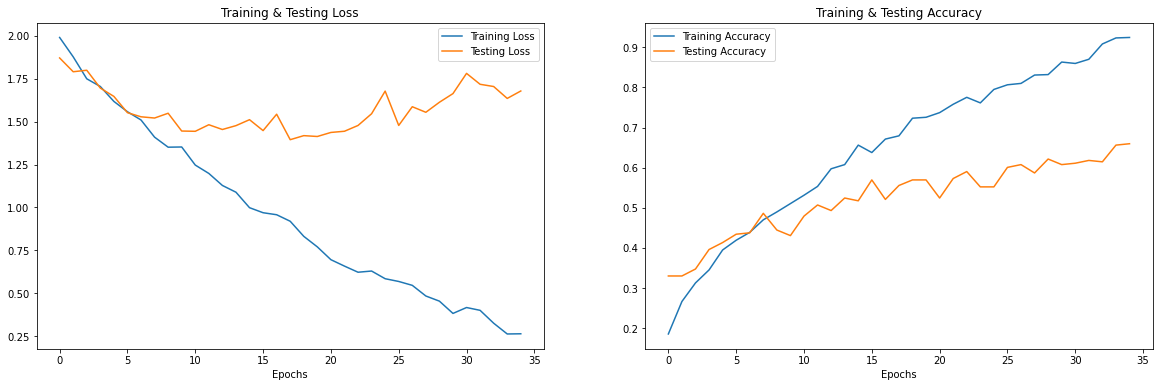

Random State : = 24
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 1s 58ms/step - loss: 2.0085 - accuracy: 0.1907 - val_loss: 1.9642 - val_accuracy: 0.2556
Epoch 2/35
14/14 [==============================] - 1s 53ms/step - loss: 1.9112 - accuracy: 0.2519 - val_loss: 1.8703 - val_accuracy: 0.3056
Epoch 3/35
14/14 [==============================] - 1s 49ms/step - loss: 1.8312 - accuracy: 0.2963 - val_loss: 1.7893 - val_accuracy: 0.3556
Epoch 4/35
14/14 [==============================] - 1s 46ms/step - loss: 1.7339 - accuracy: 0.3370 - val_loss: 1.7010 - val_accuracy: 0.4111
Epoch 5/35
14/14 [==============================] - 1s 44ms/step - loss: 1.6862 - accuracy: 0.3926 - val_loss: 1.6875 - val_accuracy: 0.3222
Epoch 6/35
14/14 [==============================] - 1s 49ms/step - loss: 1.6309 - accuracy: 0.3741 - val_loss: 1.

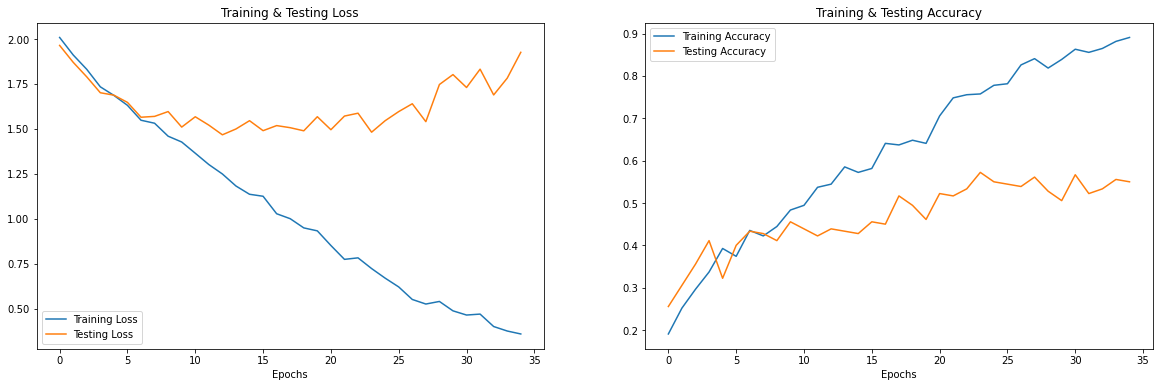

Random State : = 24
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 2s 52ms/step - loss: 2.0092 - accuracy: 0.1605 - val_loss: 1.9151 - val_accuracy: 0.2917
Epoch 2/35
17/17 [==============================] - 1s 50ms/step - loss: 1.8862 - accuracy: 0.2809 - val_loss: 1.8350 - val_accuracy: 0.2963
Epoch 3/35
17/17 [==============================] - 1s 52ms/step - loss: 1.8004 - accuracy: 0.3210 - val_loss: 1.7377 - val_accuracy: 0.3333
Epoch 4/35
17/17 [==============================] - 1s 42ms/step - loss: 1.7091 - accuracy: 0.3534 - val_loss: 1.6633 - val_accuracy: 0.4028
Epoch 5/35
17/17 [==============================] - 1s 45ms/step - loss: 1.6134 - accuracy: 0.4120 - val_loss: 1.6224 - val_accuracy: 0.4028
Epoch 6/35
17/17 [==============================] - 1s 45ms/step - loss: 1.5554 - accuracy: 0.4120 - val_loss: 1.

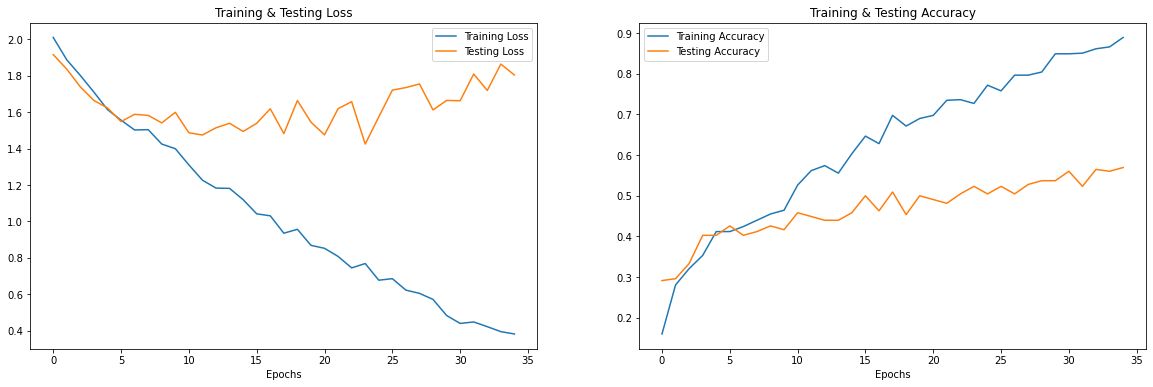

Random State : = 24
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 2s 53ms/step - loss: 2.0285 - accuracy: 0.1963 - val_loss: 1.9305 - val_accuracy: 0.2185
Epoch 2/35
21/21 [==============================] - 1s 47ms/step - loss: 1.8715 - accuracy: 0.2568 - val_loss: 1.8355 - val_accuracy: 0.3333
Epoch 3/35
21/21 [==============================] - 1s 46ms/step - loss: 1.8047 - accuracy: 0.3259 - val_loss: 1.7849 - val_accuracy: 0.2889
Epoch 4/35
21/21 [==============================] - 1s 47ms/step - loss: 1.7114 - accuracy: 0.3630 - val_loss: 1.6621 - val_accuracy: 0.3741
Epoch 5/35
21/21 [==============================] - 1s 43ms/step - loss: 1.6077 - accuracy: 0.3938 - val_loss: 1.6545 - val_accuracy: 0.3926
Epoch 6/35
21/21 [==============================] - 1s 48ms/step - loss: 1.5562 - accuracy: 0.4012 - val_loss: 1.

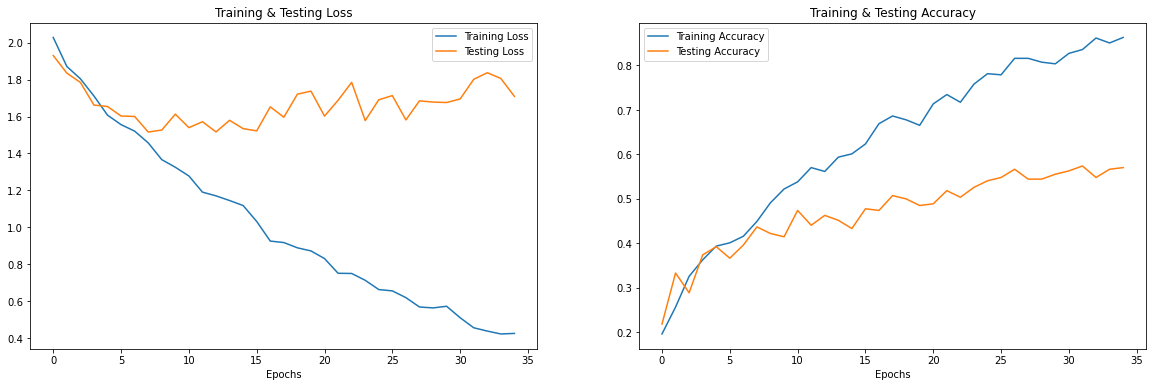

Random State : = 24
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 2s 58ms/step - loss: 1.9801 - accuracy: 0.2106 - val_loss: 1.8546 - val_accuracy: 0.2778
Epoch 2/35
22/22 [==============================] - 1s 53ms/step - loss: 1.8309 - accuracy: 0.3021 - val_loss: 1.7809 - val_accuracy: 0.3333
Epoch 3/35
22/22 [==============================] - 1s 41ms/step - loss: 1.7087 - accuracy: 0.3553 - val_loss: 1.7329 - val_accuracy: 0.3507
Epoch 4/35
22/22 [==============================] - 1s 39ms/step - loss: 1.6483 - accuracy: 0.3495 - val_loss: 1.6058 - val_accuracy: 0.3715
Epoch 5/35
22/22 [==============================] - 1s 53ms/step - loss: 1.5420 - accuracy: 0.4132 - val_loss: 1.6184 - val_accuracy: 0.3819
Epoch 6/35
22/22 [==============================] - 1s 47ms/step - loss: 1.4638 - accuracy: 0.4421 - val_loss: 1.

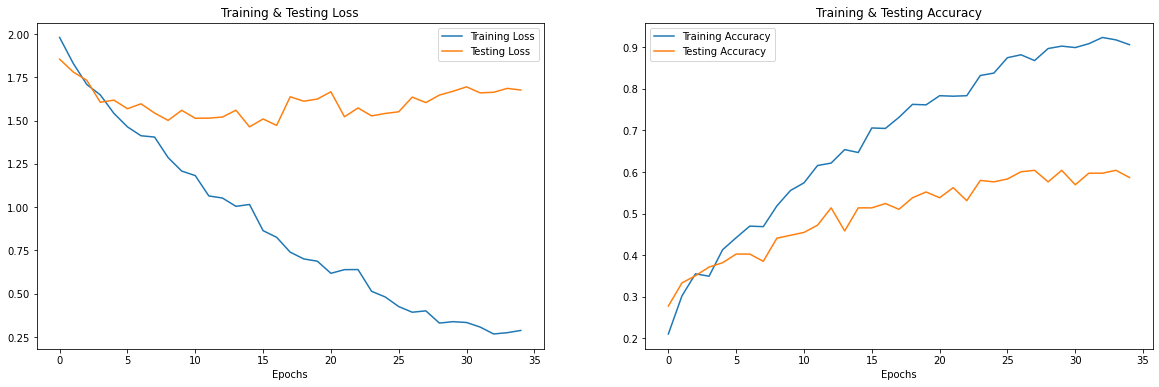

Random State : = 51
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 50%
Testing set percentage  : 50%
---------------------------
Epoch 1/35
14/14 [==============================] - 1s 71ms/step - loss: 1.9975 - accuracy: 0.1667 - val_loss: 1.8957 - val_accuracy: 0.1889
Epoch 2/35
14/14 [==============================] - 1s 57ms/step - loss: 1.9415 - accuracy: 0.2296 - val_loss: 1.8395 - val_accuracy: 0.2778
Epoch 3/35
14/14 [==============================] - 1s 57ms/step - loss: 1.8313 - accuracy: 0.2926 - val_loss: 1.8208 - val_accuracy: 0.3167
Epoch 4/35
14/14 [==============================] - 1s 52ms/step - loss: 1.7688 - accuracy: 0.3241 - val_loss: 1.7523 - val_accuracy: 0.3111
Epoch 5/35
14/14 [==============================] - 1s 43ms/step - loss: 1.6743 - accuracy: 0.3722 - val_loss: 1.7194 - val_accuracy: 0.3167
Epoch 6/35
14/14 [==============================] - 1s 40ms/step - loss: 1.6511 - accuracy: 0.3741 - val_loss: 1.

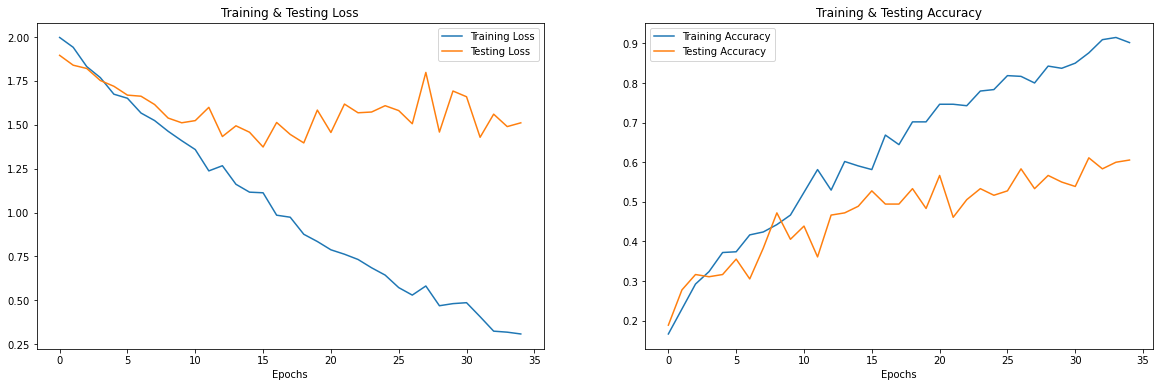

Random State : = 51
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 60%
Testing set percentage  : 40%
---------------------------
Epoch 1/35
17/17 [==============================] - 2s 86ms/step - loss: 2.0079 - accuracy: 0.1605 - val_loss: 1.8414 - val_accuracy: 0.2361
Epoch 2/35
17/17 [==============================] - 1s 51ms/step - loss: 1.8774 - accuracy: 0.2623 - val_loss: 1.8058 - val_accuracy: 0.3380
Epoch 3/35
17/17 [==============================] - 1s 52ms/step - loss: 1.7773 - accuracy: 0.3333 - val_loss: 1.7916 - val_accuracy: 0.3426
Epoch 4/35
17/17 [==============================] - 1s 44ms/step - loss: 1.7008 - accuracy: 0.3534 - val_loss: 1.7378 - val_accuracy: 0.3426
Epoch 5/35
17/17 [==============================] - 1s 45ms/step - loss: 1.6589 - accuracy: 0.3688 - val_loss: 1.7287 - val_accuracy: 0.4306
Epoch 6/35
17/17 [==============================] - 1s 45ms/step - loss: 1.5493 - accuracy: 0.4105 - val_loss: 1.

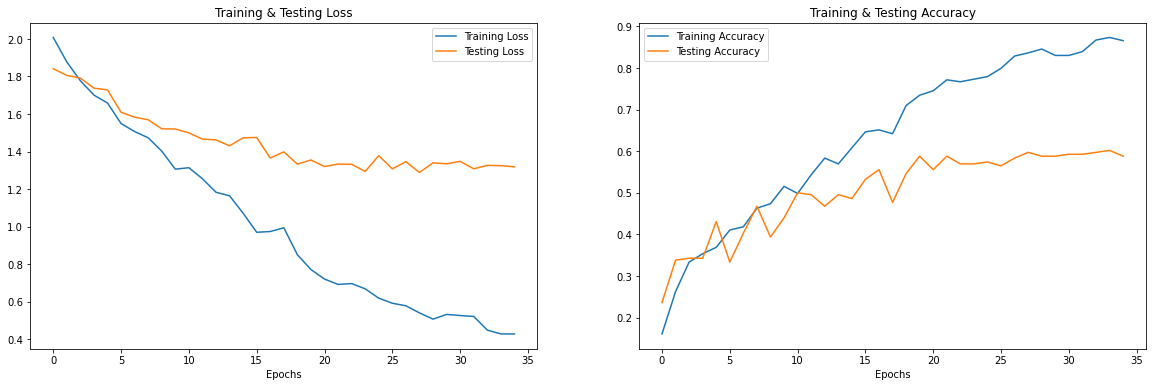

Random State : = 51
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 75%
Testing set percentage  : 25%
---------------------------
Epoch 1/35
21/21 [==============================] - 2s 59ms/step - loss: 1.9984 - accuracy: 0.1864 - val_loss: 1.8790 - val_accuracy: 0.2481
Epoch 2/35
21/21 [==============================] - 1s 59ms/step - loss: 1.8502 - accuracy: 0.2642 - val_loss: 1.8113 - val_accuracy: 0.2963
Epoch 3/35
21/21 [==============================] - 1s 50ms/step - loss: 1.7845 - accuracy: 0.2852 - val_loss: 1.7615 - val_accuracy: 0.3111
Epoch 4/35
21/21 [==============================] - 1s 46ms/step - loss: 1.6968 - accuracy: 0.3543 - val_loss: 1.7002 - val_accuracy: 0.3407
Epoch 5/35
21/21 [==============================] - 1s 53ms/step - loss: 1.6353 - accuracy: 0.3951 - val_loss: 1.6343 - val_accuracy: 0.4000
Epoch 6/35
21/21 [==============================] - 1s 42ms/step - loss: 1.5725 - accuracy: 0.3975 - val_loss: 1.

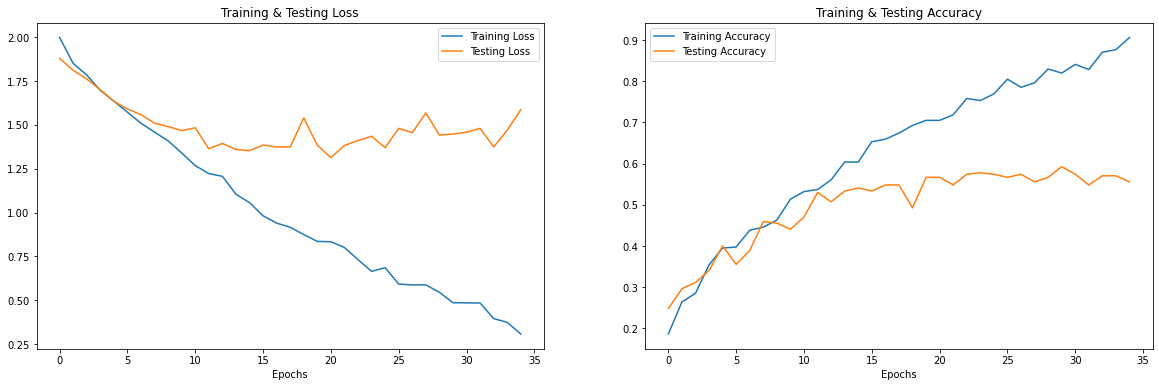

Random State : = 51
-------------------
Traning is done for Model 3
-------------------------
Training set percentage : 80%
Testing set percentage  : 20%
---------------------------
Epoch 1/35
22/22 [==============================] - 2s 54ms/step - loss: 1.9683 - accuracy: 0.2164 - val_loss: 1.8938 - val_accuracy: 0.2535
Epoch 2/35
22/22 [==============================] - 1s 55ms/step - loss: 1.8924 - accuracy: 0.2627 - val_loss: 1.8496 - val_accuracy: 0.2569
Epoch 3/35
22/22 [==============================] - 1s 59ms/step - loss: 1.8147 - accuracy: 0.2917 - val_loss: 1.7574 - val_accuracy: 0.3160
Epoch 4/35
22/22 [==============================] - 1s 48ms/step - loss: 1.7171 - accuracy: 0.3345 - val_loss: 1.6942 - val_accuracy: 0.3507
Epoch 5/35
22/22 [==============================] - 1s 48ms/step - loss: 1.6453 - accuracy: 0.3727 - val_loss: 1.6250 - val_accuracy: 0.3750
Epoch 6/35
22/22 [==============================] - 1s 45ms/step - loss: 1.5705 - accuracy: 0.3900 - val_loss: 1.

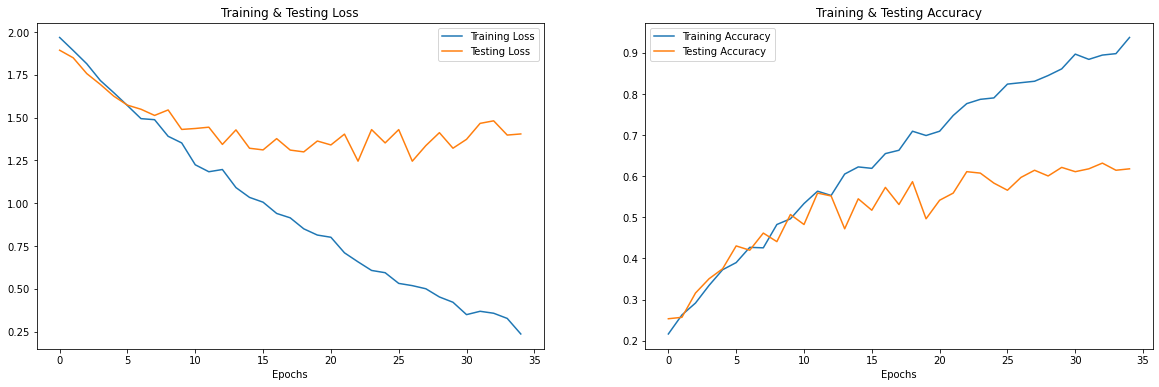

In [62]:
for x_trains,y_trains,x_tests,y_tests,rs in prog_bar(get_simple_train_test_xy(),total=5):
    Simple_Model_3_dict = {}
    Simple_Histories_3 = {}
    for k in cg:
        Simple_Model_3_dict[k] = model_3(x_trains[k])
        print(f"Random State : = {rs}")
        print("-------------------")
        print(f"Traning is done for Model 3")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        Simple_Histories_3[k] = Simple_Model_3_dict[k].fit(x_trains[k], y_trains[k], 
                                    batch_size=40, 
                                    epochs=epoch, 
                                    validation_split=.25, 
                                    callbacks=[rlrp])
        
        print("-------------------")
        print(f"Traing is done for Model 3")
        print('-------------------------')
        print(f'Training set percentage : {TTS_DICT[k][0]}%')
        print(f'Testing set percentage  : {TTS_DICT[k][1]}%')
        print('---------------------------')
        simple_model_3_acc_matrix[k].append(loss_accuracy_details(Simple_Model_3_dict[k],
                                                            Simple_Histories_3[k],
                                                            epoch,x_tests[k],
                                                            y_tests[k]
                                                            ))
        if not os.path.isdir(os.path.join(MODEL_BASE_DIR,'simple@model_3',k)):
            os.mkdir(os.path.join(MODEL_BASE_DIR,'simple@model_3',k))
        Simple_Model_3_dict[k].save(os.path.join("Models",'simple@model_3',k,f"simple@model_3_{'_'.join(TTS_DICT[k])}_{rs}.h5"))

In [63]:
simple_model_3_acc_Df = pd.DataFrame(simple_model_3_acc_matrix,index=random_states).T
path_to_model_acc_matrix = os.path.abspath('Model_Acc_Matrices')
simple_model_3_acc_Df.to_csv(os.path.join(path_to_model_acc_matrix,'simple_model_3_acc_mat.csv'))
simple_model_3_acc_Df.head()

,10,13,17,24,51
a,53.472221,54.166669,49.583334,51.249999,52.777779
b,55.208331,58.680558,52.083331,53.819442,52.777779
c,61.111110,56.666666,59.722221,57.222223,54.444444
d,58.680558,60.069442,59.027779,54.166669,60.763890


In [64]:
simple_model_3_acc_Df.T.describe()

,a,b,c,d
count,5.000000,5.000000,5.000000,5.000000
mean,52.250000,54.513888,57.833333,58.541667
std,1.840999,2.609949,2.623493,2.582081
min,49.583334,52.083331,54.444444,54.166669
25%,51.249999,52.777779,56.666666,58.680558
50%,52.777779,53.819442,57.222223,59.027779
75%,53.472221,55.208331,59.722221,60.069442
max,54.166669,58.680558,61.111110,60.763890
